In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample
#import scipy.stats as stats
import random
import re
import statistics
from scipy.stats import wilcoxon
from sklearn.metrics import roc_curve, auc

In [2]:
plt.style.use('ggplot')

In [3]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [4]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [5]:
import seaborn as sns
#sns.set_style('white')
#sns.set_context('paper') #, font_scale=2
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [6]:

def keep_max_conc(df):
    df = calc_binding_concordance(df.copy(), 'ct')
    assert df.binding_concordance.isna().any() == False
    
    dct = df.groupby(['ct']).binding_concordance.max()
    df['max_conc'] = df.ct.map(df.groupby(['ct']).binding_concordance.max())
    return df.binding_concordance == df.max_conc

def get_filtered_data(df, opt_thr):
    # Convert series of opt_thr to an exacutable and execute
    selection = eval(' & '.join(['(df.%s >= %d)'%(k,v) for k,v in opt_thr.iterrows()]))
    return selection

#def get_multiplets(df):
#    tmp = df[idx1 & df.HLA_match_per_gem]
#    dct = tmp.groupby(['ct','peptide_HLA']).gem.count() > 1
#    idx = df.set_index(['ct','peptide_HLA']).index.map(dct)
#    return idx.fillna(False)

def get_multiplets(df):
    #tmp = df[idx1 & idx2]
    dct = df.groupby(['ct','peptide_HLA']).gem.count() > 1
    idx = df.set_index(['ct','peptide_HLA']).index.map(dct)
    return idx.fillna(False)

def get_unique_entries(df):
    return np.where((df.cdr3_TRA==a) & (df.cdr3_TRB==b), False, True)

def get_sample_size():
    inter_entries = get_unique_entries(inter_chains)
    inter_indexes = inter_chains[inter_entries].index.to_list()
    #print(sum(inter_entries), len(inter_indexes), sum(get_unique_entries(group)))
    return min(sum(get_unique_entries(group)), len(inter_indexes))

def add_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T 
    return mat_a.add(mat_b)

def avg_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T.to_frame().T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T.to_frame().T
    return pd.concat([mat_a, mat_b], ignore_index=True).mean() #.to_frame() is important?

def get_intra_similarity(cdr3_TRAs, cdr3_TRBs, method='sum'):
    unique_entries = get_unique_entries(group)
    unique_entry_indexes = group[unique_entries].index.to_list()

    sample_size = get_sample_size() 
    # Am I cheating myself by having the chance of not sampling the most similar chains?
    # There can be quite substantial size differences: 100x
    
    sampled_idxs = random.sample(unique_entry_indexes, sample_size)
    intra_a = group.loc[sampled_idxs, 'cdr3_TRA'].values
    intra_b = group.loc[sampled_idxs, 'cdr3_TRB'].values
    
    if method == 'sum':
        combined_similarity = add_similarity_scores(intra_a, intra_b)
    else:
        combined_similarity = avg_similarity_scores(intra_a, intra_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def get_inter_similarity(cdr3_TRAs, cdr3_TRBs, method='sum'):
    # OBS! make sure the size to sample from matches the number og unique entries intra_similarity! 
    unique_entries = get_unique_entries(inter_chains)
    unique_entry_indexes = inter_chains[unique_entries].index.to_list()

    sample_size = get_sample_size() # Am I cheating myself by having the chance of not sampling the most similar chains?

    sampled_idxs = random.sample(unique_entry_indexes, sample_size)
    inter_a = inter_chains.loc[sampled_idxs, 'cdr3_TRA'].values
    inter_b = inter_chains.loc[sampled_idxs, 'cdr3_TRB'].values
    
    if method == 'sum':
        combined_similarity = add_similarity_scores(inter_a, inter_b)
    else:
        combined_similarity = avg_similarity_scores(inter_a, inter_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def paired_t_test(x1 ,x2):
    assert len(x1) == len(x2)
    statistic, pvalue = stats.ttest_rel(x1, x2)
    if (pvalue/2.0 < 0.05) & (statistic > 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}

def t_test(x1, x2):
    statistic, pvalue = stats.ttest_ind(x1, x2, equal_var=False, nan_policy='omit', alternative='less')
    if (pvalue < 0.05) & (statistic < 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}
    
def wilcoxon_test(intra, inter):
    w, p = wilcoxon(np.array(intra)-np.array(inter), alternative='greater')
    if (p < 0.05) & (len(intra) > 9):
        return {'test':True, 'pvalue':p}
    else:
        return {'test':False, 'pvalue':p}

def add_number_of_observations(intra_lst, inter_lst):
    for box, lst in enumerate([intra_lst, inter_lst], start=1):
        if lst:
            median = statistics.median(lst)
            plt.text(box, median, "n: %i" %len(lst), ha='center', va='bottom')

def add_significance_bar(data, hue=False, value=None, labels=None):
    print('adding significance bars')
    h1 = 1.02
    h2 = 1.025
    h3 = 1.03
    h4 = 1.035
    
    if hue:
        print('with hue')
        hue1, hue2 = data[hue].unique()
        
        y0 = data[value].max()
        y1 = y0 * h1
        y2 = y0 * h2
        y3 = y0 * h3
        y4 = y0 * h4
        
        for i,l in enumerate(data[labels].unique()):
            intra_lst = data.loc[(data[labels] == l) & (data[hue] == hue1), value]
            inter_lst = data.loc[(data[labels] == l) & (data[hue] == hue2), value]
            
            t = paired_t_test(intra_lst, inter_lst)
            print(t)
            if t['test'] and t['pvalue'] < 0.05:
                pass
            else:
                return
            
            x1, x2 = i-0.2, i+0.2
            plt.plot([x1,x1,x2,x2], [y1,y2,y2,y1], lw=1.5, c='k')
            plt.text(i, y3, "p = %.2e" %t['pvalue'], ha='center', va='bottom', color='k')
            plt.plot(1, y4)
            
    else:
        print('without hue')
        intra_lst, inter_lst = data
        if len(intra_lst) == len(inter_lst):
            t = paired_t_test(intra_lst, inter_lst)#['pvalue']
            x = [1,1,2,2]
        else:
            t = t_test(intra_lst, inter_lst)
            x = [0,0,1,1]
        print(t)
        if t['test'] and t['pvalue'] < 0.05:
            pass
        else:
            return

        y0 =  max(max(intra_lst), max(inter_lst))
        y1 = y0 * h1
        y2 = y0 * h2
        y3 = y0 * h3
        y4 = y0 * h4
        
        print('plotting')
        plt.plot(x, [y1,y2,y2,y1], lw=1.5, c='k')
        plt.text(np.mean(x), y3, "p = %.2e" %t['pvalue'], ha='center', va='bottom', color='k')
        plt.plot(1, y4)
    
def add_counts(ax, plt_df, x_col, y_col, order, hue=None):
    print('add counts')
    if hue is None:
        d = 1
    else:
        d = len(hue)
    
    y_lim = ax.get_ylim()
    y_rng = (y_lim[1] - y_lim[0]) * 0.01
    ax.set_ylim(y_lim[0]-2*y_rng, y_lim[1])
    y_min = round(ax.get_ylim()[0], 2) #y_lim[0]-y_rng
    x_pos = np.arange(len(order))
    y_pos = pd.Series([y_min]*len(order), index=order)
    counts = plt_df.dropna()[x_col].value_counts()/d
    counts = counts.reindex(order)
    
    if len(order) > 5:
        txt = '{:.0f}'
    else:
        txt = 'N={:.0f}'

    for p,n,m in zip(x_pos,counts,y_pos):
        print(p,n,m)
        if not np.isnan(m):
            ax.annotate(txt.format(n), xy=(p, m), xycoords='data', ha='center', va='bottom')
    

def plot_boxplot(intra_lst, inter_lst, title='Pooled'):
    plt.figure(figsize=(3,5))
    plt.boxplot([intra_lst, inter_lst], labels=['intra', 'inter'], widths=(0.5, 0.5))
    plt.title(title)
    plt.xlim(0.6, 2.4)
    plt.ylabel("Similarity")
    
    add_number_of_observations(intra_lst, inter_lst)
    add_significance_bar((intra_lst, inter_lst))
    
    #plt.show()

    #plt.savefig(get_file('boxplot'), bbox_inches='tight')
    #plt.cla()   # Clear axis
    #plt.clf()   # Clear figure
    #plt.close()

def plot_pieplot(significant_count, total_peptides):
    plt.pie([significant_count, total_peptides-significant_count],
            labels=['significant', 'insignificant'],
            autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * total_peptides / 100, p))
    plt.title("Proportion of significant outcomes (%i)" %total_peptides)
    plt.savefig(get_file('pieplot'), bbox_inches='tight')
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure
    plt.close()

def add_data(scores, peptide, hue, filtering, random_sample):
    n = len(scores)
    pep_lst = [peptide] * n
    hue_lst = [hue] * n
    flt_lst = [filtering] * n
    rnd_lst = [random_sample] * n
    
    g = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB'])
    
    cdr3s = list(zip(g.cdr3_TRA.values, g.cdr3_TRB.values))
    cts = g.ct.values
    
    assert len(cdr3s) == n
    assert len(cts) == n
    
    tmp = pd.DataFrame(np.array([scores, pep_lst, hue_lst, flt_lst, rnd_lst, cdr3s, cts]).T,
                       columns=['score','peptide','plateau','filtering', 'rnd_sample','cdr3s','ct'])
    tmp.score = tmp.score.astype(float)
    tmp.set_index(['plateau','rnd_sample','filtering','peptide','ct'], inplace=True)
    #tmp.index = pd.MultiIndex.from_product([plateaus, random_sampling, filterings, peptides, clonotypes],
    #                                       names=['plateau', 'rnd_sample','filtering','peptide','ct'])
    return tmp

In [7]:
def notnan(x):
    return x == x

# Input

In [8]:
CAT_DIR = '/home/tuba/herpov/tcr-pmhc-sc-project/experiments/exp13/run2/cat/'
CAT_DIR = '../experiments/exp13/run1_archive/cat/'
CAT_DIR = '../experiments/exp13/run3/cat/'

In [9]:
# OBS old
INPUT = CAT_DIR + 'tables/tcr_barcode.cleaned.csv'
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

In [10]:
VALID = CAT_DIR + "eval_clonotypes/valid_ct.csv"
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/valid_ct.csv'

In [11]:
THRESHOLD = CAT_DIR + "eval_clonotypes/threshold/opt.csv"

In [12]:
HTO = '../experiments/exp13/run1_archive/brc/outfile.csv'
HTO = '../experiments/exp13/run3/brc/outfile.csv'

In [13]:
GEX = '../experiments/exp13/run1_archive/tcr/usable_gems.txt'
GEX = '../experiments/exp13/run3/cat/tables/gex_filtering.txt'
TCR = '../experiments/exp13/run1/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'
TCR_ARC = '../experiments/exp13/run1_archive/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'

In [14]:
RANDOM_FOREST = 'tmp_files/random_forest_test.csv'
RANDOM_FOREST = 'tmp_files/random_forest_onehot.csv'

In [14]:
#TABLE = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/concordance_gridsearch.csv'

In [15]:
SIM_TRA = CAT_DIR + "/similarity_assessment/cdr3_a.csv"
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/similarity_assessment/cdr3/kernel_similarity_scores/cdr3_a.csv'
SIM_TRB = CAT_DIR + "/similarity_assessment/cdr3_b.csv"
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/similarity_assessment/cdr3/kernel_similarity_scores/cdr3_b.csv'

In [16]:
IDX_TRA = CAT_DIR + "/similarity_assessment/a_cdr3_all.txt"
IDX_TRB = CAT_DIR + "/similarity_assessment/b_cdr3_all.txt"

# Output

In [16]:
PLT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/exp9.2_IONTORRENT_KMA_AKB/grid_search_similarity/'

# Load

In [15]:
hto = pd.read_csv(HTO, skiprows=1, header=None,
                  names=['gem','seurat','umi_count_hto','feature_rna','count_hto','feature_hto',
                         'hto_max_id','hto_sec_id','hto_margin','hto_classification','hto_global_class','hash_id'])

In [17]:
tcr = pd.read_csv(TCR)
tcr_dct = tcr.groupby('barcode').is_cell.unique().apply(lambda x: x[0])
tcr_arc = pd.read_csv(TCR_ARC)
arc_dct = tcr_arc.groupby('barcode').is_cell.unique().apply(lambda x: x[0])
tcr_cell = pd.merge(arc_dct,tcr_dct, left_index=True,right_index=True, how='outer', suffixes=['_arc','_gex'])

gex = pd.read_csv(GEX, header=None, names=['gem'])

In [19]:
rnd_frst = pd.read_csv(RANDOM_FOREST)

In [20]:
rnd_frst

,gem,rf_pred
0,AAACCTGAGCCCAGCT-1,1
1,AAACCTGAGTCAATAG-1,1
2,AAACCTGCAATCCGAT-1,1
3,AAACCTGCAGCCAGAA-1,1
4,AAACCTGCATGCCACG-1,1
...,...,...
7120,TTTGGTTGTTGAGGTG-1,1
7121,TTTGTCAAGAATGTTG-1,1
7122,TTTGTCAAGCGTGAAC-1,1
7123,TTTGTCATCACCTCGT-1,1


In [18]:
#df = pd.read_csv(INPUT, converters=converters) #
df = pd.read_csv(VALID, converters=converters) #

In [19]:
#df = pd.merge(df, hto, how='left', on='gem')
#df.hto_global_class.fillna('Singlet', inplace=True)
df['gex'] = df.gem.isin(gex.gem)
#df['gex'] = df.gem.map(tcr_dct)
df = pd.merge(df, tcr_cell, left_on='gem',right_index=True)

In [23]:
df = pd.merge(df, rnd_frst, on='gem', how='left')

In [20]:
df.single_barcode_mhc = np.where(df.single_barcode_mhc, 'pMHC singlet','pMHC multiplet')
df['clonotype_multiplet'] = df.ct.map(df.groupby('ct').size() > 1)

In [25]:
#valid_df = pd.read_csv(VALID, converters=converters).fillna('') #.fillna(0)

In [26]:
#table = pd.read_csv(TABLE,index_col=0) #_archive

In [21]:
idx_tra = np.loadtxt(IDX_TRA, dtype=str)
idx_trb = np.loadtxt(IDX_TRB, dtype=str)

In [22]:
sim_tra = pd.read_csv(SIM_TRA, index_col=0).rename(index={'missing':''}, columns={'missing':''})
sim_trb = pd.read_csv(SIM_TRB, index_col=0).rename(index={'missing':''}, columns={'missing':''})

KeyboardInterrupt: 

In [23]:
sim_tra = pd.read_csv(SIM_TRA, header=None, names=idx_tra)
sim_trb = pd.read_csv(SIM_TRB, header=None, names=idx_trb)

In [24]:
sim_tra.index = idx_tra
sim_trb.index = idx_trb

In [25]:
sim_tra

,CAAADRGSTLGRLYF,CAAAGNKLTF,CAAAGNTPLVF,CAAAGTASKLTF,CAAAGYGGATNKLIF,CAAAKTSYDKVIF,CAAALYNNNDMRF,CAAANNDMRF,CAAANSGYALNF,CAAAPDTDKLIF,...,CWLTYSGGGADGLTF,CYEVGNFNKFYF,CYGHPFSGGYNKLIF,CYGRDGNTPLVF,CYGREDNAGGTSYGKLTF,CYGRGNTDKLIF,CYGRNNQGGKLIF,CYGTSGTYKYIF,CYNFNKFYF,CYPDTPLVF
CAAADRGSTLGRLYF,1.000000,0.808049,0.796182,0.830478,0.804110,0.801701,0.749666,0.770549,0.815228,0.786575,...,0.743593,0.728354,0.714730,0.764284,0.741939,0.778345,0.761517,0.761781,0.677745,0.698807
CAAAGNKLTF,0.808049,1.000000,0.903056,0.901963,0.822561,0.837046,0.796848,0.890072,0.873390,0.839107,...,0.748643,0.779641,0.730709,0.796248,0.710608,0.817945,0.786103,0.794208,0.753680,0.769716
CAAAGNTPLVF,0.796182,0.903056,1.000000,0.882573,0.808867,0.826364,0.780512,0.851579,0.857145,0.843593,...,0.738669,0.753642,0.721264,0.846681,0.699077,0.809269,0.756253,0.787907,0.714962,0.809841
CAAAGTASKLTF,0.830478,0.901962,0.882573,1.000000,0.840810,0.864090,0.771014,0.824808,0.874462,0.849193,...,0.765712,0.742465,0.721276,0.775925,0.730424,0.801690,0.750919,0.806413,0.691265,0.744739
CAAAGYGGATNKLIF,0.804110,0.822561,0.808867,0.840809,1.000000,0.790147,0.750751,0.759741,0.825988,0.768538,...,0.782906,0.725008,0.762414,0.754788,0.740947,0.781018,0.758913,0.771174,0.663569,0.676418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CYGRGNTDKLIF,0.778345,0.817945,0.809269,0.801690,0.781019,0.801590,0.768022,0.796548,0.783031,0.818557,...,0.744158,0.796652,0.747193,0.844239,0.731101,1.000000,0.828956,0.814455,0.748781,0.752960
CYGRNNQGGKLIF,0.761517,0.786103,0.756253,0.750919,0.758913,0.746647,0.744051,0.760509,0.773723,0.730456,...,0.736727,0.751822,0.741544,0.799295,0.746207,0.828956,1.000000,0.760885,0.716344,0.691534
CYGTSGTYKYIF,0.761781,0.794208,0.787907,0.806414,0.771174,0.806439,0.731098,0.747223,0.801924,0.763286,...,0.741047,0.787348,0.758818,0.791534,0.716178,0.814455,0.760885,1.000000,0.765415,0.746274
CYNFNKFYF,0.677745,0.753680,0.714962,0.691265,0.663569,0.726829,0.737421,0.753827,0.739913,0.697196,...,0.640496,0.860277,0.702949,0.725514,0.621728,0.748781,0.716344,0.765415,1.000000,0.745505


In [28]:
sim_tra = sim_tra[~sim_tra.index.duplicated()].copy() # Necessary?
sim_trb = sim_trb[~sim_trb.index.duplicated()].copy()

In [26]:
df.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0}, inplace=True)

In [27]:
opt_thr = pd.read_csv(THRESHOLD, index_col=0, header=None, names=['thr']).thr.dropna()
#opt_idx = get_filtered_data(df, opt_thr.dropna())
#opt_thr.umi_count_cd8 = 0
#opt_thr.delta_umi_cd8 = 0
opt_thr

umi_count_mhc    2.000000
delta_umi_mhc    1.113500
umi_count_TRA    0.000000
delta_umi_TRA    0.757858
umi_count_TRB    0.000000
delta_umi_TRB    0.757858
Name: thr, dtype: float64

In [28]:
# For the similarity computation we don't want to include clonotypes that are missing a chain
df.dropna(subset=['cdr3_TRA','cdr3_TRB'], inplace=True)
# when filtering for optimal threshold it is important to have values in UMI and delta
df.fillna(value={"umi_count_mhc": 0, "delta_umi_mhc": 0, "umi_count_mhc_rel":0,
                 "umi_count_cd8": 0, "delta_umi_cd8": 0,
                 "umi_count_TRA": 0, "delta_umi_TRA": 0,
                 "umi_count_TRB": 0, "delta_umi_TRB": 0}, inplace=True) #df.fillna(0) 
df.replace('0','', inplace=True) # why?
#df.sort_values(by='rank', inplace=True)
df.sort_values(by='epitope_rank', inplace=True)
df['HLA_match_per_gem'] = df.apply(lambda row: row.HLA_mhc in row.HLA_cd8 if row.HLA_cd8 == row.HLA_cd8 else False, axis=1)

In [29]:
#idx1 = eval(' & '.join([f'(df.{k} >= {abs(v)})' for k,v in opt_thr.items()]))
#idx2 = df.hto_global_class == 'Singlet'
#idx3 = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if (notnan(row.peptide_HLA) & notnan(row.HLA_cd8)) else False, axis=1)
#idx4 = df['exclude_single-chain_TCRs']
#idx5 = get_multiplets(df)

In [30]:
idx0 = ~df.gem.isna()
idx1 = eval(' & '.join([f'(df.{k} >= {abs(v)})' for k,v in opt_thr.items()]))
idx2 = df.hto_global_class == 'Singlet'
idx3 = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if (notnan(row.peptide_HLA) & notnan(row.HLA_cd8)) else False, axis=1)
idx4 = df['exclude_single-chain_TCRs']
idx5 = get_multiplets(df)

idx6 = df.is_cell_arc
idx7 = df.is_cell_gex
idx8 = df.gex

In [50]:
filter_set = 'rnd_frst'
idx0 = ~df.gem.isna()
idx1 = df.rf_pred_1_None == 1
idx2 = df.rf_pred_1_15 == 1
idx3 = df.rf_pred_1_10 == 1
idx4 = df.rf_pred_1_5 == 1
idx5 = df.rf_pred_5_None == 1
idx6 = df.rf_pred_5_15 == 1
idx7 = df.rf_pred_5_10 == 1
idx8 = df.rf_pred_5_5 == 1
idx9 = df.rf_pred_10_None == 1
idx10 = df.rf_pred_10_15 == 1
idx11 = df.rf_pred_10_10 == 1
idx12 = df.rf_pred_10_5 == 1
idx13 = df.rf_pred_15_None == 1
idx14 = df.rf_pred_15_15 == 1
idx15 = df.rf_pred_15_10 == 1
idx16 = df.rf_pred_15_5 == 1

filterings = [idx0,
              idx1,
              idx3,
              idx2,
              idx4,
              idx5,
              idx6,
              idx7,
              idx8, idx9,idx10,idx11,idx12,idx13,idx14,idx15,idx16]
labels = ['total',
          's1_dn','s1_d15','s1_d10','s1_d5',
          's5_dn','s5_d15','s5_d10','s5_d5',
          's10_dn','s10_d15','s10_d10','s10_d5',
          's15_dn','s15_d15','s15_d10','s15_d5']
palette = sns.color_palette("husl")

In [31]:
# Showing individual effects of filtering
filter_set = 'indv'
filterings = [idx0,
              idx1,
              idx3,
              idx2,
              idx4,
              idx5,
              idx6,
              idx7,
              idx8]
labels = ['total','optimal threshold',
          'matching HLA',
          'hashing singlets',
          'complete TCRs',
          'specificity multiplets',
          'is cell',
          'is cell (GEX)',
          'is viable cell']
palette = ['grey','yellow','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494','black']

In [59]:
# Showing combined effects in the same order
filter_set = 'comb'
filterings = [idx0,
              idx1,
              (idx1 & idx3),
              (idx1 & idx2 & idx3),
              (idx1 & idx2 & idx3 & idx4),
              (idx1 & idx2 & idx3 & idx4 & idx5),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx6),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx7),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx8)]
labels = ['total','optimal threshold',
          'matching HLA',
          'hashing singlets',
          'complete TCRs',
          'specificity multiplets',
          'is cell',
          'is cell (GEX)',
          'is viable cell']
palette = ['grey','yellow','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494','black']

In [35]:
# Showing combined effects in the same order
filter_set = 'rnd_frst_oh'
filterings = [idx0,
              idx1,
              (idx1 & idx3),
              (idx1 & idx2 & idx3 & idx4 & idx5),
              (idx1 & idx2 & idx3 & idx4 & idx5 & idx6),
              (df.rf_pred == 1)]
labels = ['total','optimal threshold',
          'matching HLA',
          'specificity multiplets',
          'is cell','random_forest_oh']
palette = ['grey','yellow','#ffffcc','#41b6c4','#2c7fb8','black']

In [33]:
## Showing individual effects of filtering
#filterings = [idx0,
#              idx1,
#              idx3 & idx1,
#              idx3 & idx1 & idx2,
#              idx3 & idx1 & idx4,
#              idx3 & idx1 & idx5,
#              idx3 & idx1 & idx6,
#              idx3 & idx1 & idx7,
#              idx3 & idx1 & idx8]
#labels = ['total','optimal threshold',
#          'matching HLA',
#          'hashing singlets',
#          'complete TCRs',
#          'specificity multiplets',
#          'is cell',
#          'is cell (GEX)',
#          'is viable cell']
#palette = ['grey','yellow','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494','black']

In [60]:
peptides = df.peptide_HLA.unique()
#['total','optimal threshold', 'GEX filtering','hashing singlets', 'matching HLA', 'Complete TCRs','specificity multiplets']
plateaus = ['intra','inter']
#filtering = ['raw','optimal threshold','hashing singlets', 'matching HLA', 'Complete TCRs','specificity multiplets']
random_sampling = np.arange(30)
clonotypes = df.ct.unique()

indexes = len(peptides)*len(plateaus)*len(labels)*len(random_sampling)*len(clonotypes)

# Initiate dataframe
test_df = pd.DataFrame(columns=['score','cdr3s'], index=np.arange(indexes))
test_df.index = pd.MultiIndex.from_product([plateaus, random_sampling, labels, peptides, clonotypes],
                                           names=['plateau', 'rnd_sample','filtering','peptide','ct'])

In [61]:
test_df

score cdr3s
plateau rnd_sample filtering      peptide           ct                
intra   0          total          GILGFVFTL A0201   604.0    NaN   NaN
                                                    848.0    NaN   NaN
                                                    22.0     NaN   NaN
                                                    2190.0   NaN   NaN
                                                    278.0    NaN   NaN
...                                                          ...   ...
inter   29         is viable cell TPSVSSSISSL B0702 1411.0   NaN   NaN
                                                    2187.0   NaN   NaN
                                                    2140.0   NaN   NaN
                                                    1239.0   NaN   NaN
                                                    1732.0   NaN   NaN

[11210940 rows x 2 columns]

In [62]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [63]:
score_dct = dict()
plt_df = pd.DataFrame(columns=['score','peptide','plateau','filtering','rnd_sample','cdr3s','ct'])
intra_df = pd.DataFrame(columns=['score','peptide','plateau','filtering','rnd_sample','cdr3s','ct'])
inter_df = pd.DataFrame(columns=['score','peptide','plateau','filtering','rnd_sample','cdr3s','ct'])

#filtering = ['raw','optimal threshold','HLA match', 'specificity multiplets'] #['raw','thr']
#filtering = ['raw','optimal threshold','hashing singlets', 'matching HLA', 'Complete TCRs','specificity multiplets']
#for data_type, sdf in zip(filtering, [df, df[opt_idx], df[opt_idx & df.HLA_match_per_gem], df[get_multiplets(df)]]):
#for data_type, sdf in zip(filtering, [df, df[idx1], df[idx1 & idx2], df[idx1 & idx2 & idx3],
#                                      df[idx1 & idx2 & idx3 & idx4], df[idx1 & idx2 & idx3 & idx4 & idx5]]):
for data_type, flt in zip(labels, filterings):
    print(data_type)
    sdf = df[flt]
    sdf = sdf[keep_max_conc(sdf)]
    for peptide, group in sdf.groupby('peptide_HLA', sort=False):
        #print(peptide)
        if len(group) == 1:
            continue
        if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
            continue

        inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

        #intra_score_peptide = list()
        #inter_score_peptide = list()  

        # OBS! Maybe get the pairs directly instead of zipping them?
        # Make sure you get true pairs and not just random pairs?!
        cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
        cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values

        assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())
        
        for random_sample in random_sampling:
            intra_score_peptide = list()
            inter_score_peptide = list()
            for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
                intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
                inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

                intra_score_peptide.append(intra['score'])
                inter_score_peptide.append(inter['score'])

            #intra_df = pd.concat([intra_df, add_data(intra_score_peptide, peptide, 'intra', data_type, random_sample)])
            #inter_df = pd.concat([inter_df, add_data(inter_score_peptide, peptide, 'inter', data_type, random_sample)])
            
            for pl, lst in zip(['intra','inter'], [intra_score_peptide, inter_score_peptide]):
                tmp = add_data(lst, peptide, pl, data_type, random_sample)
                test_df.loc[tmp.index, ['score','cdr3s']] = tmp

    #plt_df = pd.concat([intra_df,inter_df])
    #score_dct[data_type] = list(intra_df[intra_df.filtering == data_type].score -
    #                            inter_df[inter_df.filtering == data_type].score)

total
optimal threshold
matching HLA
hashing singlets
complete TCRs
specificity multiplets
is cell
is cell (GEX)
is viable cell


In [64]:
test_df.reset_index(inplace=True)

In [65]:
test_df.score = test_df.score.astype(float)

In [65]:
import glob
files = glob.glob('../experiments/exp10x/run1/cat/similarity_assessment/sim_pep/comb/1/*.csv')
dfs = list()
for f in files:
    tmp = pd.read_csv(f, header=None, names=['plateau', 'rnd_sample','filtering','peptide','ct','score','cdr3'])
    dfs.append(tmp)
test_df = pd.concat(dfs, ignore_index=True)

In [66]:
test_df

,plateau,rnd_sample,filtering,peptide,ct,score,cdr3
0,intra,1,total,RPPIFIRRL B0702,69633,1.817148,"('CAVSDSNYQLIW', 'CASSDSSGRDTQYF')"
1,intra,1,total,RPPIFIRRL B0702,32858,1.733812,"('CLVGGSGSARQLTF', 'CASSRTAVGNTIYF')"
2,intra,1,total,RPPIFIRRL B0702,33589,1.777250,"('CAVRDSNYQLIW', 'CASSVGGDGGYGYTF')"
3,intra,1,total,RPPIFIRRL B0702,32783,1.664711,"('CVVNSFSGAGSYQLTF', 'CASSPLGGKNTGELFF')"
4,intra,1,total,RPPIFIRRL B0702,31767,1.797958,"('CAVMDSNYQLIW', 'CASSETSGGAYEQYF')"
...,...,...,...,...,...,...,...
33335,inter,1,total,CLGGLLTMV A0201,82541,1.633140,"('CALSVIKAAGNKLTF', 'CSASGTSHNEQFF')"
33336,inter,1,total,CLGGLLTMV A0201,45966,1.558933,"('CALGPSVGGYQKVTF', 'CASSYSRGQGVTNTEAFF')"
33337,inter,1,total,CLGGLLTMV A0201,34884,1.557166,"('CAMSAEGAGNNRKLIW', 'CASSPKTGTSQETQYF')"
33338,inter,1,total,CLGGLLTMV A0201,75326,1.582787,"('CAAIIPSGTYKYIF', 'CSAPARSEPYEQYF')"


In [67]:
test_df['label'] = np.where(test_df.plateau == 'intra', 2, 0)

In [68]:
# compute AUC for each sample
for s, s_grp in test_df.dropna().groupby('rnd_sample'):
    print(s)
    for f, f_grp in s_grp.groupby('filtering'):
        fpr, tpr, _ = roc_curve(f_grp.label, f_grp.score, pos_label=2)
        test_df.loc[f_grp.index, 'AUC'] = auc(fpr, tpr)
        test_df.loc[f_grp.index, 'AUC 0.1'] = auc(fpr[fpr < 0.1], tpr[fpr < 0.1])/ 0.1

1


### Save dataframe to file

In [68]:
#test_df.to_csv('similarity.%s.csv' %filter_set, index=False)
FILENAME = '../experiments/exp13/run3/cat/similarity_assessment/plt_df/%s.sim.csv'%filter_set
test_df.to_csv(FILENAME, index=False)

In [69]:
filter_set

'comb'

### Load file

In [9]:
#test_df = pd.read_csv('similarity.csv') #similarity.indv.csv
test_df = pd.read_csv('similarity.%s.csv'%filter_set) #similarity.comb.csv #'similarity_accumulated.csv'

In [70]:
auc_df = test_df.dropna().melt(id_vars=['rnd_sample', 'filtering'], value_vars=['AUC','AUC 0.1'])
auc_df

,rnd_sample,filtering,variable,value
0,1,total,AUC,0.531022
1,1,total,AUC,0.531022
2,1,total,AUC,0.531022
3,1,total,AUC,0.531022
4,1,total,AUC,0.531022
...,...,...,...,...
66675,1,total,AUC 0.1,0.069748
66676,1,total,AUC 0.1,0.069748
66677,1,total,AUC 0.1,0.069748
66678,1,total,AUC 0.1,0.069748


In [71]:
auc_df.filtering.unique()

array(['total', 'optimal threshold', 'matching HLA', 'hashing singlets',
       'complete TCRs', 'specificity multiplets', 'is cell',
       'is cell (GEX)', 'is viable cell'], dtype=object)

In [21]:
#auc_df.to_csv('similarity.auc.%s.csv' %filter_set, index=False)
#FILENAME = '../experiments/exp13/run3/cat/similarity_assessment/plt_df/%s.auc.csv'%filter_set
FILENAME = '../experiments/exp10x/run1/cat/similarity_assessment/plt_df/%s.auc.csv'%'10x_icon'
auc_df.to_csv(FILENAME, index=False)

# Plot similarity metrics

In [22]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=1.5)

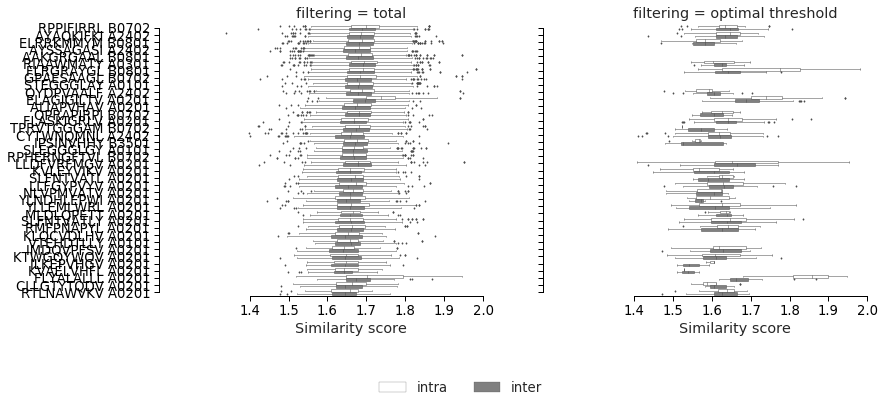

In [23]:
selected_filters = ['total','optimal threshold']
g = sns.catplot(y="peptide",
                x="score",
                hue="plateau", palette=['white','grey'],
                col="filtering",
                data=test_df[test_df.filtering.isin(selected_filters)],
                kind="box",sharey=True,
                legend=False, linewidth=0.5, fliersize=1, aspect=1.2)

for ax, flt in zip(g.axes[0], selected_filters):
    ct_per_pep = test_df[(test_df.rnd_sample==0) &
                         (test_df.plateau == 'intra') & 
                         (test_df.filtering == flt)].dropna().groupby(['peptide'],sort=False).size()
    for i,n in enumerate(ct_per_pep):
        ax.annotate(f'{n}', xy=(ax.get_xlim()[0],i), xytext=(-10, -1), textcoords='offset points', va='center', ha='right')

g.set_xlabels('Similarity score')
g.set_ylabels('') #Peptide HLA
#g.set_xticklabels(rotation=90, ha='center')
#plt.xticks(rotation=90, ha='center')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='center', frameon=False, ncol=2, bbox_transform=g.fig.transFigure)
#plt.legend(bbox_to_anchor=(1.2, 0.5), loc=6, frameon=False)
sns.despine(trim=True, offset={'left':55})
plt.subplots_adjust(wspace=0.40) #38

#plt.savefig(snakemake.output.score_per_pep, bbox_inches='tight')
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/sim.%s.png' %filter_set, bbox_inches='tight', dpi=300)
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/sim.%s.png' %filter_set, bbox_inches='tight', dpi=300)
plt.show()

In [170]:
df.loc[~df.VDJdb_check.isna(), ['gem','ct','clonotype','genes_lst_TRA','genes_lst_TRB','cdr3_TRA','cdr3_TRB',
                                'peptide_HLA_lst','peptide_HLA','ct_pep', 'HLA_cd8',
                                'VDJdb_check','umi_count_lst_mhc','delta_umi_mhc']]#.gem

,gem,ct,clonotype,genes_lst_TRA,genes_lst_TRB,cdr3_TRA,cdr3_TRB,peptide_HLA_lst,peptide_HLA,ct_pep,HLA_cd8,VDJdb_check,umi_count_lst_mhc,delta_umi_mhc
2695,GACTACAGTCAGCTAT-1,3697.0,clonotype3697,['TRAV9-2;TRAJ34;TRAC'],['TRBV3-1;;TRBJ2-7;TRBC2'],CALYNTDKLIF,CASSPTSGSVYEQYF,"[RVRAYTYSK A0301, GLCTLVAML A0201]",GLCTLVAML A0201,NaN,[A0201],True,"[6.0, 23.0]",3.680000
2208,CTAGTGATCCATGCTC-1,883.0,clonotype883,['TRAV5;TRAJ31;TRAC'],['TRBV20-1;TRBD1;TRBJ1-2;TRBC1'],CAEDNNARLMF,CSARDGTGNGYTF,"[RVRAYTYSK A0301, GLCTLVAML A0201]",GLCTLVAML A0201,NaN,"[A0201, B0702]",True,"[9.0, 23.0]",2.486486
2155,CTACCCAGTTCCGGCA-1,5316.0,clonotype5316,['TRAV26-2;TRAJ43;TRAC'],['TRBV7-6;;TRBJ1-4;TRBC1'],CIRDNNNDMRF,CASSLAPGATNEKLFF,"[CLGGLLTMV A0201, RVRAYTYSK A0301, NLVPMVATV A...",NLVPMVATV A0201,NaN,"[A0201, A0301]",True,"[2.0, 21.0, 26.0]",1.223529
3660,GTTCGGGTCGCACTCT-1,5317.0,clonotype5317,['TRAV26-2;TRAJ43;TRAC'],['TRBV7-6;;TRBJ1-4;TRBC1'],CILDNNNDMRF,CASSLAPGATNEKLFF,[NLVPMVATV A0201],NLVPMVATV A0201,NaN,[A0201],True,[24.0],96.000000
1172,CACAGGCTCGAGAACG-1,162.0,clonotype162,['TRAV17;TRAJ11;TRAC'],['TRBV6-5;;TRBJ1-2;TRBC1'],CATEGDSGYSTLTF,CASSYQGGNYGYTF,"[CLGGLLTMV A0201, FLYALALLL A0201]",FLYALALLL A0201,FLYALALLL A0201,"[A0201, A0301]",True,"[1.0, 38.0]",30.400000
3435,GTATTCTAGTAGCCGA-1,162.0,clonotype162,['TRAV17;TRAJ11;TRAC'],['TRBV6-5;;TRBJ1-2;TRBC1'],CATEGDSGYSTLTF,CASSYQGGNYGYTF,"[YVLDHLIVV A0201, TPRVTGGGAM B0702, FLYALALLL ...",FLYALALLL A0201,FLYALALLL A0201,"[A0201, A0301]",True,"[1.0, 1.0, 33.0]",26.400000
1958,CGGCTAGTCTGCAAGT-1,162.0,clonotype162,['TRAV17;TRAJ11;TRAC'],['TRBV6-5;;TRBJ1-2;TRBC1'],CATEGDSGYSTLTF,CASSYQGGNYGYTF,"[CLGGLLTMV A0201, RVRAYTYSK A0301, TPSVSSSISSL...",FLYALALLL A0201,FLYALALLL A0201,"[A0201, A0301]",True,"[1.0, 1.0, 1.0, 1.0, 22.0]",17.600000
2183,CTAGCCTAGTCCAGGA-1,162.0,clonotype162,['TRAV17;TRAJ11;TRAC'],['TRBV6-5;;TRBJ1-2;TRBC1'],CATEGDSGYSTLTF,CASSYQGGNYGYTF,"[CLGGLLTMV A0201, RVRAYTYSK A0301, FLYALALLL A...",FLYALALLL A0201,FLYALALLL A0201,"[A0201, A0301]",True,"[2.0, 2.0, 46.0]",20.444444
626,AGATCTGTCACTCTTA-1,2840.0,clonotype2840,['TRAV17;TRAJ11;TRAC'],['TRBV6-5;;TRBJ1-2;TRBC1'],CATEGDSGYSTLTF,CASSLQGGNYGYTF,[FLYALALLL A0201],FLYALALLL A0201,NaN,"[A0201, A0301]",True,[17.0],68.000000
3909,TAGTTGGAGTATCGAA-1,1178.0,clonotype1178,['TRAV5;TRAJ37;TRAC'],['TRBV29-1;;TRBJ1-4;TRBC1'],CAESIGKLIF,CSVGAGGTNEKLFF,"[GLCTLVAML A0201, RVRAYTYSK A0301]",RVRAYTYSK A0301,NaN,[A0201],False,"[8.0, 11.0]",1.333333


In [169]:
df[(df.cdr3_TRA == 'CAESIGKLIF') & (df.cdr3_TRB == 'CSVGAGGTNEKLFF')]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,hto_sec_id,hto_margin,hto_classification,hto_global_class,hash_id,gex,is_cell_arc,is_cell_gex,clonotype_multiplet,HLA_match_per_gem
3909,TAGTTGGAGTATCGAA-1,clonotype1178,1178.0,1178.0,TRAV5;TRAJ37;TRAC,TRBV29-1;;TRBJ1-4;TRBC1,['TRAV5;TRAJ37;TRAC'],['TRBV29-1;;TRBJ1-4;TRBC1'],491.0,DSSSTY,...,10.0,3.453266,1_10,Doublet,Doublet,False,True,True,False,False


In [56]:
#test_df.filtering = np.where(test_df.filtering == 'is functional cell', 'is viable cell', test_df.filtering)

In [100]:
# INDV
test_df[(test_df.rnd_sample==0) &
        (test_df.plateau == 'intra') &
        (test_df.filtering == 'total')].dropna().groupby('peptide').ct.nunique()

peptide
CLGGLLTMV A0201        49
FLYALALLL A0201        22
GILGFVFTL A0201         4
GLCTLVAML A0201        11
NLVPMVATV A0201         7
RPHERNGFTV B0702       72
RPHERNGFTVL B0702      54
RPPIFIRRL B0702        50
RVRAYTYSK A0301      1333
TPRVTGGGAM B0702      254
TPSVSSSISSL B0702      64
VLEETSVML A0201        53
YVLDHLIVV A0201       109
Name: ct, dtype: int64

In [114]:
# COMB
test_df[(test_df.rnd_sample==5) &
        (test_df.plateau == 'intra') &
        (test_df.filtering == 'total')].dropna().groupby('peptide').ct.nunique()

peptide
CLGGLLTMV A0201        49
FLYALALLL A0201        22
GILGFVFTL A0201         4
GLCTLVAML A0201        11
NLVPMVATV A0201         7
RPHERNGFTV B0702       72
RPHERNGFTVL B0702      54
RPPIFIRRL B0702        50
RVRAYTYSK A0301      1332
TPRVTGGGAM B0702      254
TPSVSSSISSL B0702      63
VLEETSVML A0201        53
YVLDHLIVV A0201       109
Name: ct, dtype: int64

In [105]:
# INDV
test_df[(test_df.rnd_sample==0) &
        (test_df.plateau == 'intra') &
        (test_df.filtering == 'total')].dropna().groupby('ct').size()

ct
1.0       1
2.0       1
3.0       1
4.0       1
5.0       1
         ..
7052.0    1
7055.0    1
7064.0    1
7069.0    1
7079.0    1
Length: 2007, dtype: int64

In [104]:
# INDV
test_df[(test_df.rnd_sample==0) &
        (test_df.plateau == 'intra') &
        (test_df.filtering == 'total')].dropna().shape

(2082, 10)

In [24]:
rnd_sample = 1 #0
lst_scores = test_df[test_df.rnd_sample == rnd_sample].dropna().groupby(['filtering','plateau']).score.apply(list).to_frame().reset_index()
lst_lst_scores = lst_scores.groupby('filtering', sort=False).score.apply(list)
sign_test = lst_lst_scores.apply(lambda x: wilcoxon_test(x[-1],x[0])['test']) #wilcoxon_test()

In [25]:
lst_scores

,filtering,plateau,score
0,complete TCRs,inter,"[1.6666790000000002, 1.618398, 1.6085470000000..."
1,complete TCRs,intra,"[1.633358, 1.633358, 1.599483, 1.603926, 1.513..."
2,icon,inter,"[1.597212, 1.524082, 1.5948950000000002, 1.569..."
3,icon,intra,"[1.611805, 1.510586, 1.614989, 1.5953309999999..."
4,icon matching HLA,inter,"[1.594433, 1.575021, 1.598224, 1.520088, 1.552..."
5,icon matching HLA,intra,"[1.614989, 1.615269, 1.635439, 1.587642, 1.569..."
6,is cell,inter,"[1.5867330000000002, 1.6789619999999998, 1.520..."
7,is cell,intra,"[1.530135, 1.5415230000000002, 1.5546950000000..."
8,matching HLA,inter,"[1.6349900000000002, 1.605378, 1.6255800000000..."
9,matching HLA,intra,"[1.633358, 1.633358, 1.599483, 1.603926, 1.513..."


In [34]:
labels = ['total','no negatives','optimal threshold','matching HLA','complete TCRs','specificity multiplets','is cell','icon','icon matching HLA']

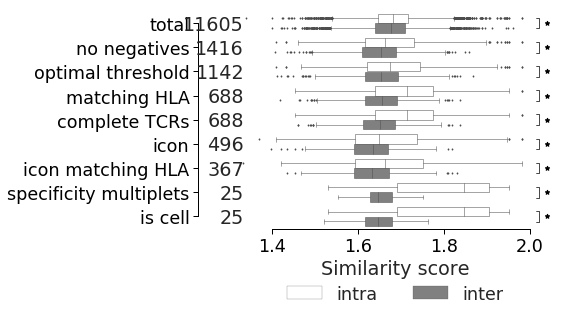

In [35]:
##########################
#   Plot pooled scores   #
##########################
#fig = plt.figure()
ax = sns.boxplot(y="filtering", x="score", hue="plateau", palette=['white','grey'], data=test_df, linewidth=0.5, fliersize=1)
#add_significance_bar(plt_df, value='score', hue='plateau', labels='filtering')
ax.set_xlabel('Similarity score')
ax.set_ylabel('')

# Annotate counts
ct_per_flt = test_df[(test_df.rnd_sample==rnd_sample) &
                     (test_df.plateau == 'intra')].dropna().groupby(['filtering'],sort=False).size()
for i,n in enumerate(ct_per_flt):
    ax.annotate(f'{n}', xy=(ax.get_xlim()[0],i), xytext=(15, -1), textcoords='offset points', va='center', ha='right')

# Add significance bar
for i, c in enumerate(labels):
    if sign_test[c]:
        y = [i+0.22, i+0.22, i-0.22, i-0.22] #[0,0,1,1] #
        x0 = 2
        x1 = x0 * 1.007
        x2 = x0 * 1.010
        x3 = x0 * 1.020

    ax.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
    ax.plot(x3, np.mean(y), marker="*", c='0')
            
#for i, c in enumerate(labels):
#    ann = '*' if sign_test[c] else ''
#    ax.annotate(ann, xy=(2, i), #p.get_width()
#        xytext=(5, -1), textcoords='offset points', ha="left", va="center", size=12)

plt.legend(bbox_to_anchor=(0.5, -0.3), ncol=2, loc=10, frameon=False)
sns.despine(trim=True, offset={'left':30})
#plt.savefig(snakemake.output.score_pooled, bbox_inches='tight')
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/sim.pool.%s.png' %filter_set, bbox_inches='tight',dpi=300)
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/sim.pool.%s.png' %filter_set, bbox_inches='tight',dpi=300)
plt.show()

#plt_df.to_csv(snakemake.output.score_pooled[:-3] + 'csv', index=False)

In [ ]:
###########################
# Plot scores per peptide #
###########################
# FIX ME!
# The numbers under the plot dont match?!
#fig = plt.figure()
g = sns.catplot(x="peptide",
                y="score",
                hue="plateau",
                row="filtering",
                data=plt_df[plt_df.filtering.isin(['raw','optimal threshold'])],
                kind="box",
                aspect=2.5, sharey=True,
                legend=False)

for ax, flt in zip(g.axes, ['raw','optimal threshold']):
    add_counts(ax[0], plt_df[plt_df.filtering == flt],
               "peptide", "score",
               plt_df.peptide.unique(),
               ['intra','inter'])
    
g.set_ylabels('Similarity score')
g.set_xlabels('Peptide HLA')
g.set_xticklabels(rotation=90, ha='center')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc='center', frameon=False)
sns.despine(trim=True)
#plt.savefig(snakemake.output.score_per_pep, bbox_inches='tight')
plt.show()

##########################
#   Plot pooled scores   #
##########################
#fig = plt.figure()
ax = sns.boxplot(x="filtering", y="score", hue="plateau", data=plt_df)
add_significance_bar(plt_df, value='score', hue='plateau', labels='filtering')
ax.set_ylabel('Similarity score')
ax.set_xlabel('')
add_counts(ax, plt_df, "filtering", "score", filtering, ['intra','inter'])
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center', frameon=False)
sns.despine(trim=True)
#plt.savefig(snakemake.output.score_pooled, bbox_inches='tight')
plt.show()

#plt_df.to_csv(snakemake.output.score_pooled[:-3] + 'csv', index=False)

#############################
# Plot pooled, delta scores #
#############################
#fig = plt.figure()
comp_df = pd.DataFrame.from_dict(score_dct, orient='index').T
comp_df = pd.melt(comp_df, value_vars=['raw','optimal threshold'])
#comp_df.to_csv(snakemake.output.score_pooled_delta[:-3] + 'csv', index=False)
ax = sns.boxplot(x='variable',y='value', data=comp_df)
#ax.set_xticklabels(comp_df.peptide.unique(), rotation=90, ha='center')
add_significance_bar((comp_df[comp_df.variable == 'raw'].value.dropna(),
                     comp_df[comp_df.variable == 'optimal threshold'].value.dropna()))
add_counts(ax, comp_df, "variable", "value", filtering)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta$ similarity score')
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
sns.despine(trim=True, bottom=False) #, offset={'bottom':20}
#plt.savefig(snakemake.output.score_pooled_delta, bbox_inches='tight')
plt.show()



# Plot AUC

In [28]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

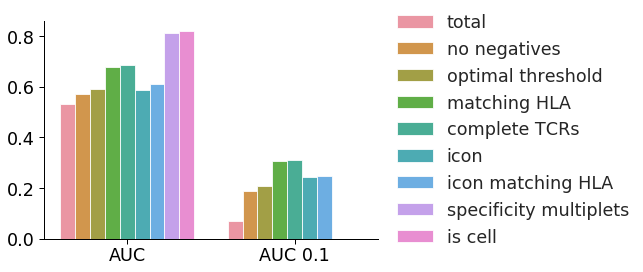

In [71]:
sns.barplot(data=auc_df, hue='filtering',y='value',x='variable', ci='sd') #palette=palette, 
plt.legend(bbox_to_anchor=(1.01, 0.5), loc=6, frameon=False)
plt.ylabel('')
plt.xlabel('')
sns.despine()
#plt.xticks(rotation=90)
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/auc.bar.%s.png' %filter_set, bbox_inches='tight', dpi=300)
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/auc.bar.%s.png' %filter_set, bbox_inches='tight', dpi=300)

In [72]:
test_df.groupby('filtering').AUC.mean()

filtering
complete TCRs             0.683390
icon                      0.586856
icon matching HLA         0.610519
is cell                   0.817600
matching HLA              0.675636
no negatives              0.571401
optimal threshold         0.591788
specificity multiplets    0.811200
total                     0.531022
Name: AUC, dtype: float64

In [73]:
test_df.groupby('filtering')['AUC 0.1'].mean()

filtering
complete TCRs             0.311872
icon                      0.243080
icon matching HLA         0.246749
is cell                   0.000000
matching HLA              0.304420
no negatives              0.186025
optimal threshold         0.207633
specificity multiplets    0.000000
total                     0.069748
Name: AUC 0.1, dtype: float64

In [75]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, flt in test_df.dropna().groupby('filtering'):
    fpr[i], tpr[i], _ = roc_curve(flt.label, flt.score, pos_label=2)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [76]:
roc_auc

{'complete TCRs': 0.683389974249139,
 'icon': 0.586856,
 'icon matching HLA': 0.610518626734843,
 'is cell': 0.8175999999999999,
 'matching HLA': 0.6756358980587021,
 'no negatives': 0.5714011616327139,
 'optimal threshold': 0.5917875708805529,
 'specificity multiplets': 0.8111999999999999,
 'total': 0.53102235267064}

In [77]:
palette = sns.color_palette("husl", 10)

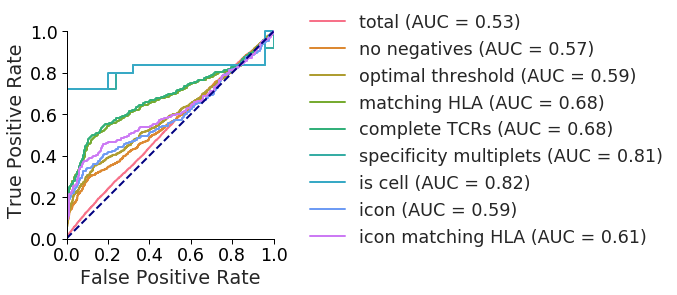

In [79]:
plt.figure()
lw = 2
for k,c in zip(labels,palette):
    plt.plot(fpr[k], tpr[k], c=c, lw=lw, label="%s (AUC = %0.2f)" %(k, roc_auc[k]))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.gca().set_aspect('equal', 'box')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("Receiver operating characteristic example")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc=6, frameon=False)
sns.despine(trim=True)
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/auc.roc.%s.png' %filter_set, bbox_inches='tight', dpi=300)
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/auc.roc.%s.png' %filter_set, bbox_inches='tight', dpi=300)
plt.show()

In [82]:
print('jej')

jej


# Preprocess

## Calc relative UMI counts

In [25]:
df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'label', 'umi_count_mhc', 'umi_count_lst_mhc', 'delta_umi_mhc',
       'single_barcode_mhc', 'multiplets_mhc', 'umi_count_cd8',
       'umi_count_lst_cd8', 'delta_umi_cd8', 'single_barcode_cd8',
       'multiplets_cd8', 'detected_response', 'peptide_assayed', 'sample_id',
 

In [28]:
for ct, grp in df.groupby('ct'):
    umi_rel = grp.umi_count_mhc / grp.umi_count_mhc.quantile(0.9, interpolation='lower') #.max()
    df.loc[umi_rel.index, 'umi_count_mhc_rel'] = umi_rel

## Select the data to compute similarity on

In [19]:
# OBS! rel
#thr = (valid_df.umi_count_mhc_rel >= 0.034483) & (valid_df.delta_umi_mhc >= 5) & (valid_df.umi_count_TRB >= 1) & (valid_df.delta_umi_TRB >= 6)
thr = (valid_df.umi_count_mhc >= 14) & (valid_df.delta_umi_mhc >= 2) & (valid_df.umi_count_TRB >= 0) & (valid_df.delta_umi_TRB >= 5)

In [20]:
valid_df['epitope_rank'] = epitope_sorter_index(valid_df)
train = valid_df[thr].replace('0','').copy()
train = calc_binding_concordance(train, 'ct')

In [31]:
# OBS! rel
#thr = (df.umi_count_mhc_rel >= 0.034483) & (df.delta_umi_mhc >= 5) & (df.umi_count_TRB >= 1) & (df.delta_umi_TRB >= 6)
thr = (df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) & (df.umi_count_TRA >= 0) & (df.delta_umi_TRB >= 0)

In [22]:
test = df[~df.ct.isin(valid_df.ct) & thr].copy()
test['epitope_rank'] = epitope_sorter_index(test)
test = calc_binding_concordance(test, 'ct')

In [32]:
total = df[thr].copy()
#total['epitope_rank'] = epitope_sorter_index(total)
total = calc_binding_concordance(total, 'ct')

In [24]:
trash = df[~thr].copy()
trash['epitope_rank'] = epitope_sorter_index(trash)
trash = calc_binding_concordance(trash, 'ct')

In [26]:
dataset = 'all.total.14.2.0.5' #'new.train.14.2.0.5' #
sdf = df.dropna(subset=['cdr3_TRA','cdr3_TRB']).copy() #total

In [27]:
# Retain only highest concordance specificities
#dct = sdf.groupby('ct').binding_concordance.max()
#sdf['max_concordance'] = sdf.ct.map(dct)
#sdf = sdf[sdf.max_concordance == sdf.binding_concordance].copy()

In [28]:
sdf.replace('0','', inplace=True)

In [29]:
def add_data(scores, peptide, group, data_type):
    n = len(scores)
    print(n)
    peptides = [peptide] * n
    groups = [group] * n
    types = [data_type] * n
    tmp = pd.DataFrame(np.array([scores, peptides, groups, types]).T,
                       columns=['score','peptide','plateau','filtering'])
    tmp.score = tmp.score.astype(float)
    return tmp

In [43]:
df.sort_values(by='rank', inplace=True)
df['HLA_match_per_gem'] = df.apply(lambda row: row.HLA_mhc in row.HLA_cd8 if row.HLA_cd8 == row.HLA_cd8 else False, axis=1)

In [44]:
score_dct = dict()
plt_df = pd.DataFrame(columns=['score','peptide','plateau','filtering','cdr3s','ct'])
intra_df = pd.DataFrame(columns=['score','peptide','plateau','filtering','cdr3s','ct'])
inter_df = pd.DataFrame(columns=['score','peptide','plateau','filtering','cdr3s','ct'])

filtering = ['raw','optimal threshold','HLA match', 'specificity multiplets'] #['raw','thr']
for data_type, sdf in zip(filtering, [df, df[opt_idx], df[opt_idx & df.HLA_match_per_gem], df[get_multiplets(df)]]):
    sdf = sdf[keep_max_conc(sdf)]
    for peptide, group in sdf.groupby('peptide_HLA', sort=False):
        print(peptide)
        if len(group) == 1:
            continue
        if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
            continue

        inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

        intra_score_peptide = list()
        inter_score_peptide = list()  

        # OBS! Maybe get the pairs directly instead of zipping them?
        # Make sure you get true pairs and not just random pairs?!
        cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
        cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values

        assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())

        for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
            intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
            inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

            intra_score_peptide.append(intra['score'])
            inter_score_peptide.append(inter['score'])

        intra_df = pd.concat([intra_df, add_data(intra_score_peptide, peptide, 'intra', data_type)])
        inter_df = pd.concat([inter_df, add_data(inter_score_peptide, peptide, 'inter', data_type)])

    plt_df = pd.concat([intra_df,inter_df])
    score_dct[data_type] = list(intra_df[intra_df.filtering == data_type].score -
                                inter_df[inter_df.filtering == data_type].score)

GILGFVFTL A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


KeyError: '[nan] not in index'

CLGGLLTMV A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


FLYALALLL A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecate

GILGFVFTL A0201
GLCTLVAML A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecate

NLVPMVATV A0201
RPHERNGFTV B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RPHERNGFTVL B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RPPIFIRRL B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RVRAYTYSK A0301


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TPRVTGGGAM B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TPSVSSSISSL B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


VLEETSVML A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


YVLDHLIVV A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CLGGLLTMV A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecate

FLYALALLL A0201
GILGFVFTL A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecate

GLCTLVAML A0201
NLVPMVATV A0201
RPHERNGFTV B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RPHERNGFTVL B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RPPIFIRRL B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RVRAYTYSK A0301


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TPRVTGGGAM B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TPSVSSSISSL B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


VLEETSVML A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


YVLDHLIVV A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


add counts
0 61.0 1.43
1 27.0 1.43
2 5.0 1.43
3 13.0 1.43
4 11.0 1.43
5 88.0 1.43
6 60.0 1.43
7 66.0 1.43
8 1372.0 1.43
9 296.0 1.43
10 86.0 1.43
11 64.0 1.43
12 122.0 1.43
add counts
0 29.0 1.42
1 19.0 1.42
2 2.0 1.42
3 5.0 1.42
4 4.0 1.42
5 19.0 1.42
6 36.0 1.42
7 23.0 1.42
8 1123.0 1.42
9 153.0 1.42
10 24.0 1.42
11 25.0 1.42
12 94.0 1.42


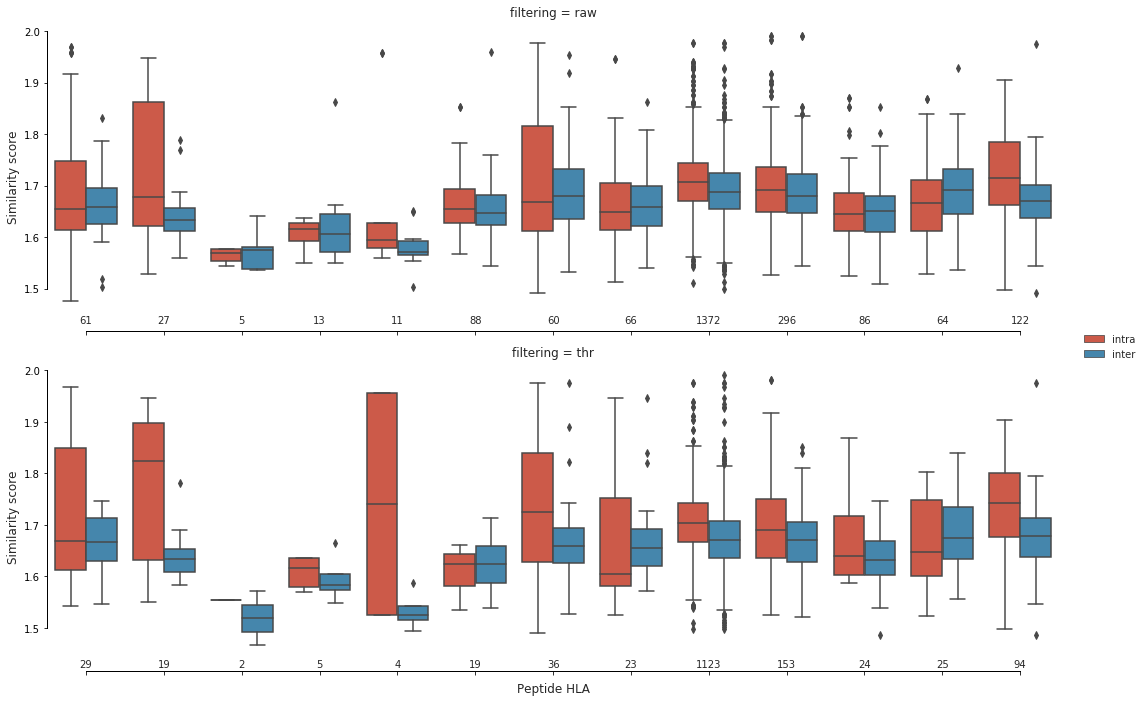

add counts
0 2271.0 1.43
1 1556.0 1.43


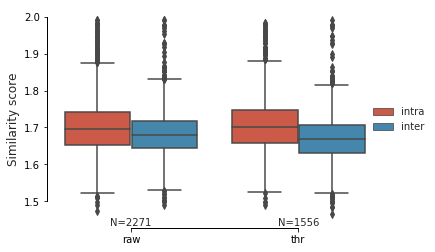

adding significance bars


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

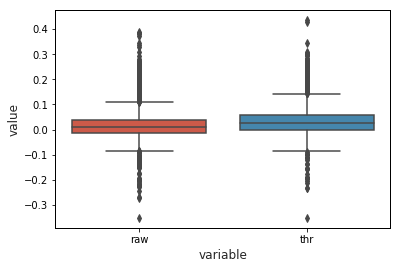

In [36]:
# TEST WITH SNS
import seaborn as sns
#sns.set_style('white')
#sns.set_context('paper') #, font_scale=2
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

#significant_simulations = list()
#n_simulations = 10
score_dct = dict()
plt_df = pd.DataFrame(columns=['score','peptide','plateau','filtering'])
intra_df = pd.DataFrame(columns=['score','peptide','plateau','filtering'])
inter_df = pd.DataFrame(columns=['score','peptide','plateau','filtering'])

#for simulation in range(n_simulations):
for data_type, sdf in [('raw', df.dropna(subset=['cdr3_TRA','cdr3_TRB']).replace('0','').fillna(0)),
                       ('thr', total.dropna(subset=['cdr3_TRA','cdr3_TRB']).replace('0','').fillna(0))]:

    intra_score = list()
    inter_score = list()
    for peptide, group in sdf.groupby('peptide_HLA'):
        print(peptide)
        if len(group) == 1:
            continue
        if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
            continue

        inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

        intra_score_peptide = list()
        inter_score_peptide = list()  

        # OBS! Maybe get the pairs directly instead of zipping them? Make sure you get true pairs and not just random pairs?!
        cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
        cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values

        assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())

        for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
            intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
            inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

            intra_score_peptide.append(intra['score'])
            inter_score_peptide.append(inter['score'])

            intra_score.append(intra['score'])
            inter_score.append(inter['score'])

        intra_df = pd.concat([intra_df, add_data(intra_score_peptide, peptide, 'intra', data_type)])
        inter_df = pd.concat([inter_df, add_data(inter_score_peptide, peptide, 'inter', data_type)])

        #intra_df = pd.DataFrame(intra_score_peptide, columns=['score'])
        #inter_df = pd.DataFrame(inter_score_peptide, columns=['score'])
        #intra_df['group'] = 'intra'
        #inter_df['group'] = 'inter'
        #intra_df['peptide'] = peptide
        #inter_df['peptide'] = peptide

        


        tnobs = len(intra_score_peptide)
        idx = random.sample(list(np.arange(len(intra_score_peptide))), tnobs)
        ass = list(np.array(intra_score_peptide)[idx])
        ess = list(np.array(inter_score_peptide)[idx])
        #plot_boxplot(ass, ess, title=peptide)
        #plt.savefig('tcr_similarity.%s.%s.pdf'%(dataset,peptide))
        #plt.show()

    assert len(inter_score) == len(intra_score)
    #tnobs = len(intra_score)
    #intra_score_s = random.sample(intra_score, tnobs)
    #inter_score_s = random.sample(inter_score, tnobs)
    #plot_boxplot(intra_score, inter_score) #intra_score_s, inter_score_s
    #plt.savefig(PLT + 'tcr_similarity.pooled.%s.pdf'%dataset)
    #plt.show()

    # Plot scores per peptide
    plt_df = pd.concat([intra_df,inter_df])
    #ax = sns.boxplot(x='peptide',y='score', hue='plateau', data=plt_df)
    #ax.set_xticklabels(plt_df.peptide.unique(), rotation=90, ha='center')
    #plt.show()

    score_dct[data_type] = list(intra_df[intra_df.filtering == data_type].score - inter_df[inter_df.filtering == data_type].score)

# Plot scores per peptide
g = sns.catplot(x="peptide", y="score",
                 hue="plateau", row="filtering",
                 data=plt_df, kind="box", aspect=3, legend=False) #, aspect=2
for ax, flt in zip(g.axes, ['raw','thr']):
    add_counts(ax[0], plt_df[plt_df.filtering == flt], "peptide", "score", plt_df.peptide.unique(), ['intra','inter'])
g.set_ylabels('Similarity score')
g.set_xlabels('Peptide HLA')
g.fig.tight_layout()
g.set_xticklabels(rotation=90, ha='center')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc='center', frameon=False)
sns.despine(trim=True)
plt.show()

# Plot pooled scores
ax = sns.boxplot(x="filtering", y="score", hue="plateau", data=plt_df)
ax.set_ylabel('Similarity score')
ax.set_xlabel('')
add_counts(ax, plt_df, "filtering", "score", ['raw','thr'], ['intra','inter'])
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center', frameon=False)
sns.despine(trim=True)
plt.show()

# Plot pooled, delta scores
comp_df = pd.DataFrame.from_dict(score_dct, orient='index').T
comp_df = pd.melt(comp_df, value_vars=['raw','thr'])
ax = sns.boxplot(x='variable',y='value', data=comp_df)
#ax.set_xticklabels(comp_df.peptide.unique(), rotation=90, ha='center')
add_significance_bar(comp_df[comp_df.variable == 'raw'].value.dropna(),
                     comp_df[comp_df.variable == 'thr'].value.dropna())
add_counts(ax, comp_df, "variable", "value", ['raw','thr'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta$ similarity score')
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
sns.despine(trim=True, bottom=True)
plt.show()

add counts
0 61.0 1.44
1 27.0 1.44
2 5.0 1.44
3 13.0 1.44
4 11.0 1.44
5 88.0 1.44
6 60.0 1.44
7 66.0 1.44
8 1372.0 1.44
9 296.0 1.44
10 86.0 1.44
11 64.0 1.44
12 122.0 1.44
adding significance bars
with hue
{'test': True, 'pvalue': 8.986616961924705e-42}
{'test': True, 'pvalue': 4.61881394273368e-80}


NameError: name 'filtering' is not defined

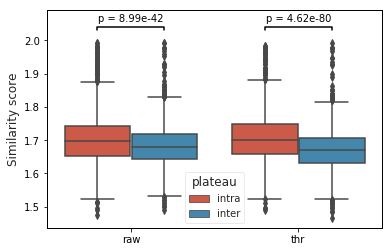

In [37]:
###########################
# Plot scores per peptide #
###########################
# FIX ME!
# The numbers under the plot dont match?!
#fig = plt.figure()
g = sns.catplot(x="peptide",
                y="score",
                hue="plateau",
                row="filtering",
                data=plt_df[plt_df.filtering.isin(['raw','optimal threshold'])],
                kind="box",
                aspect=2.5, sharey=True,
                legend=False)

for ax, flt in zip(g.axes, ['raw','optimal threshold']):
    add_counts(ax[0], plt_df[plt_df.filtering == flt],
               "peptide", "score",
               plt_df.peptide.unique(),
               ['intra','inter'])
    
g.set_ylabels('Similarity score')
g.set_xlabels('Peptide HLA')
g.set_xticklabels(rotation=90, ha='center')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc='center', frameon=False)
sns.despine(trim=True)
#plt.savefig(snakemake.output.score_per_pep, bbox_inches='tight')
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

##########################
#   Plot pooled scores   #
##########################
#fig = plt.figure()
ax = sns.boxplot(x="filtering", y="score", hue="plateau", data=plt_df)
add_significance_bar(plt_df, value='score', hue='plateau', labels='filtering')
ax.set_ylabel('Similarity score')
ax.set_xlabel('')
add_counts(ax, plt_df, "filtering", "score", filtering, ['intra','inter'])
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center', frameon=False)
sns.despine(trim=True)
#plt.savefig(snakemake.output.score_pooled, bbox_inches='tight')
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

plt_df.to_csv(snakemake.output.score_pooled[:-3] + 'csv', index=False)

#############################
# Plot pooled, delta scores #
#############################
#fig = plt.figure()
comp_df = pd.DataFrame.from_dict(score_dct, orient='index').T
comp_df = pd.melt(comp_df, value_vars=['raw','optimal threshold'])
comp_df.to_csv(snakemake.output.score_pooled_delta[:-3] + 'csv', index=False)
ax = sns.boxplot(x='variable',y='value', data=comp_df)
#ax.set_xticklabels(comp_df.peptide.unique(), rotation=90, ha='center')
add_significance_bar((comp_df[comp_df.variable == 'raw'].value.dropna(),
                     comp_df[comp_df.variable == 'optimal threshold'].value.dropna()))
add_counts(ax, comp_df, "variable", "value", filtering)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta$ similarity score')
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
sns.despine(trim=True, bottom=False) #, offset={'bottom':20}
#plt.savefig(snakemake.output.score_pooled_delta, bbox_inches='tight')
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

In [47]:
sdf[sdf.peptide_HLA == peptide]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,single_barcode_mrk,multiplets_mrk,umi_count_mhc_rel,gems_per_specificity,gems_per_clonotype,binding_concordance,cdr3_TRA_substr,cdr3_TRB_substr,VDJdb_pep,VDJdb_check
16,AAACGGGAGTGTACTC-1,clonotype18,18.0,18.0,TRAV14/DV4;TRAJ42;TRAC,TRBV20-1;;TRBJ2-6;TRBC2,['TRAV14/DV4;TRAJ42;TRAC'],['TRBV20-1;;TRBJ2-6;TRBC2'],535.0,TSDPSYG,...,0.0,0.0,0.0,51,52,0.980769,0,0,0,0
40,AAAGCAAGTACGAAAT-1,clonotype5377,5377.0,5377.0,TRAV8-1;TRAJ34;TRAC,TRBV7-6;;TRBJ2-2;TRBC2,['TRAV8-1;TRAJ34;TRAC'],['TRBV7-6;;TRBJ2-2;TRBC2'],565.0,YGGTVN,...,0.0,0.0,0.0,1,1,1.000000,0,0,0,0
70,AACACGTGTTTGTGTG-1,clonotype4711,4711.0,4711.0,TRAV8-1;TRAJ27;TRAC,TRBV7-3;;TRBJ2-2;TRBC2,['TRAV8-1;TRAJ27;TRAC'],['TRBV7-3;;TRBJ2-2;TRBC2'],565.0,YGGTVN,...,0.0,0.0,0.0,1,1,1.000000,0,0,0,0
144,AACTTTCCAATGACCT-1,clonotype35,35.0,35.0,TRAV8-1;TRAJ15;TRAC,TRBV6-2;;TRBJ2-1;TRBC2,['TRAV8-1;TRAJ15;TRAC'],['TRBV6-2;;TRBJ2-1;TRBC2'],568.0,YGGTVN,...,0.0,0.0,0.0,19,21,0.904762,0,0,0,0
162,AAGCCGCCATGCTAGT-1,clonotype1212,1212.0,1212.0,TRAV8-1;TRAJ34;TRAC,TRBV3-1;;TRBJ2-1;TRBC2,['TRAV8-1;TRAJ34;TRAC'],['TRBV3-1;;TRBJ2-1;TRBC2'],563.0,YGGTVN,...,0.0,0.0,0.0,1,1,1.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,TTCTTAGCAAACCCAT-1,clonotype35,35.0,35.0,TRAV8-1;TRAJ15;TRAC,TRBV6-2;;TRBJ2-1;TRBC2,['TRAV8-1;TRAJ15;TRAC'],['TRBV6-2;;TRBJ2-1;TRBC2'],568.0,YGGTVN,...,0.0,0.0,0.0,19,21,0.904762,0,0,0,0
4751,TTGGAACCAGGAACGT-1,clonotype2715,2715.0,2715.0,TRAV8-1;TRAJ34;TRAC,TRBV28;;TRBJ1-2;TRBC1,['TRAV8-1;TRAJ34;TRAC'],['TRBV28;;TRBJ1-2;TRBC1'],565.0,YGGTVN,...,0.0,0.0,0.0,1,1,1.000000,0,0,0,0
4799,TTTCCTCGTACCGGCT-1,clonotype18,18.0,18.0,TRAV14/DV4;TRAJ42;TRAC,TRBV20-1;;TRBJ2-6;TRBC2,['TRAV14/DV4;TRAJ42;TRAC'],['TRBV20-1;;TRBJ2-6;TRBC2'],535.0,TSDPSYG,...,0.0,0.0,0.0,51,52,0.980769,0,0,0,0
4807,TTTGCGCGTTCCCTTG-1,clonotype103,103.0,103.0,TRAV12-2;TRAJ34;TRAC,TRBV30;TRBD1;TRBJ2-1;TRBC2,['TRAV12-2;TRAJ34;TRAC'],['TRBV30;TRBD1;TRBJ2-1;TRBC2'],538.0,DRGSQS,...,0.0,0.0,0.0,7,7,1.000000,0,0,0,0


In [48]:
peptide

'YVLDHLIVV A0201'

In [37]:
plt_df[plt_df.filtering == flt].dropna()['peptide'].value_counts()

RVRAYTYSK A0301      2246
TPRVTGGGAM B0702      306
YVLDHLIVV A0201       188
RPHERNGFTVL B0702      72
CLGGLLTMV A0201        58
VLEETSVML A0201        50
TPSVSSSISSL B0702      48
RPPIFIRRL B0702        46
FLYALALLL A0201        38
RPHERNGFTV B0702       38
GLCTLVAML A0201        10
NLVPMVATV A0201         8
GILGFVFTL A0201         4
Name: peptide, dtype: int64

In [ ]:
import seaborn as sns
#sns.set_theme(color_codes=True)
iris = sns.load_dataset("iris")
species = iris.pop("species")
g = sns.clustermap(iris)

In [48]:
a = df.set_index('ct')[['cdr3_lst_TRA', 'cdr3_lst_TRB']].explode('cdr3_lst_TRA').explode('cdr3_lst_TRB')
#b = df.set_index('ct').explode('cdr3_lst_TRB')

In [49]:
a

,cdr3_lst_TRA,cdr3_lst_TRB
ct,,
4860.0,CAVGVRGGGNKLTF,CASSAGVGIVFGSGNTIYF
4860.0,CAVGVRGGGNKLTF,CASSVTGPPREDGYTF
2833.0,CATFNAGNNRKLIW,CASSLVAGGHEQYF
4.0,CAVRAITGGGNKLTF,CASSTPSSGPQETQYF
115.0,CAVLMDSNYQLIW,CASSADGMNTEAFF
...,...,...
2.0,,CASSYVGYEQYF
544.0,,CASSGAPGRNPFYEQYF
2011.0,,CSASRQGGFGNEQFF


In [56]:
sim_tra[['CAVGVRGGGNKLTF']].mean(axis=1)

CAAADRGSTLGRLYF    0.781109
CAAAGNKLTF         0.821686
CAAAGNTPLVF        0.783240
CAAAGTASKLTF       0.802031
CAAAGYGGATNKLIF    0.820995
                     ...   
CYGRNNQGGKLIF      0.793577
CYGTSGTYKYIF       0.752681
CYNFNKFYF          0.666158
CYPDTPLVF          0.673594
                   0.000000
Length: 4761, dtype: float64

In [54]:
sim_trb[['CASSAGVGIVFGSGNTIYF','CASSVTGPPREDGYTF']].mean(axis=1)

CAADYEQYF          0.659047
CAAGEGGSYNEQFF     0.718160
CAAGEGSPLHF        0.725714
CAAGGTFSYEQYF      0.716612
CAAIGGNEQYF        0.717683
                     ...   
CVPPIQQNSYNEQFF    0.663663
CYEQYF             0.573875
CYGYTF             0.601112
CYRRGRAVVGYTF      0.701862
                   0.000000
Length: 5868, dtype: float64

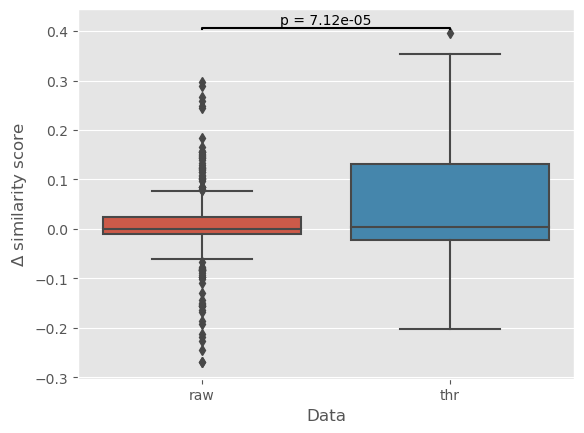

In [71]:
comp_df = pd.DataFrame.from_dict(score_dct, orient='index').T
comp_df = pd.melt(comp_df, value_vars=['raw','thr'])
ax = sns.boxplot(x='variable',y='value', data=comp_df)
#ax.set_xticklabels(comp_df.peptide.unique(), rotation=90, ha='center')
add_significance_bar(comp_df[comp_df.variable == 'raw'].value.dropna(),
                     comp_df[comp_df.variable == 'thr'].value.dropna())
ax.set_xlabel('Data')
ax.set_ylabel(r'$\Delta$ similarity score')
plt.show()

In [59]:
stats.ttest_ind(comp_df[comp_df.variable == 'raw'].value.dropna(),
                comp_df[comp_df.variable == 'thr'].value.dropna(), equal_var=False, nan_policy='omit', alternative='less')

Ttest_indResult(statistic=-3.96513282627692, pvalue=7.12088605290385e-05)

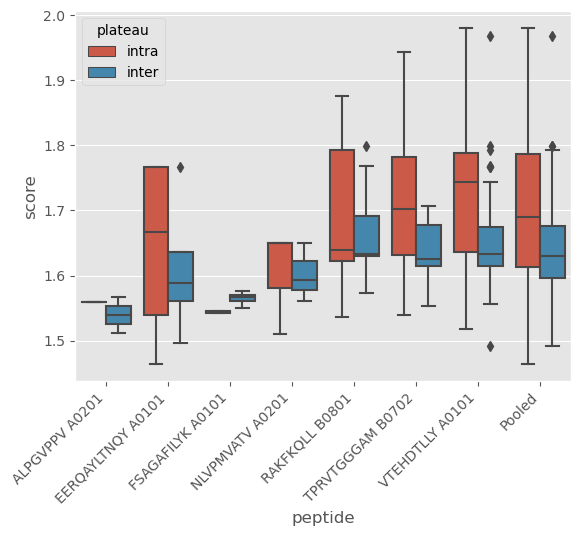

In [80]:
import seaborn as sns

ax = sns.boxplot(x='peptide',y='score', hue='plateau', data=p_df)
ax.set_xticklabels(p_df.peptide.unique(), rotation=45, ha='right')
plt.show()

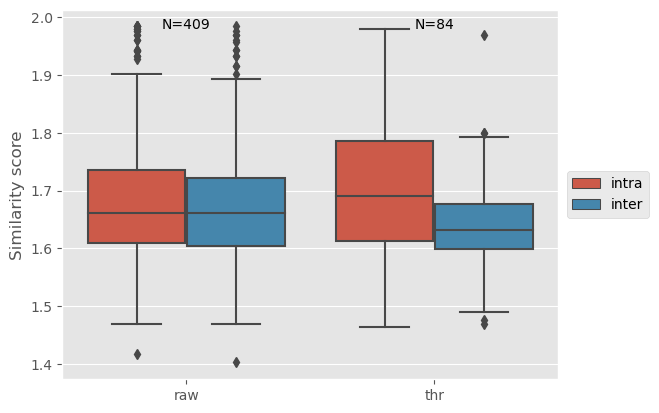

In [220]:
x_col='filtering'
y_col='score'
order=['raw','thr']
hue_col='plateau'
hue_order=['intra','inter']
width=0.8

ax = sns.boxplot(x="filtering", y="score",
                 hue="plateau",
                 data=plt_df) #, aspect=2
ax.set_ylabel('Similarity score')
ax.set_xlabel('')

#g.set_xticklabels(rotation=90, ha='center')
#plt.subplots_adjust(wspace = 0.03)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center')

#n_levels = len(plt_df[hue_col].unique())
#each_width = width / n_levels
#offsets = np.linspace(0, width - each_width, n_levels)
#offsets -= offsets.mean()
#
#pos = [x+o for x in np.arange(len(order)) for o in offsets]
#
#counts = plt_df.groupby([x_col,hue_col])[y_col].size()
#counts = counts.reindex(pd.MultiIndex.from_product([order,hue_order]))
#medians = plt_df.groupby([x_col,hue_col])[y_col].median()
#medians = medians.reindex(pd.MultiIndex.from_product([order,hue_order]))
#
#pos = [0,1]
#counts = plt_df.groupby([x_col])[y_col].size()/2
#counts = counts.reindex(order)
#medians = pd.Series([2]*2, index=order)
#
#for p,n,m in zip(pos,counts,medians):
#    if not np.isnan(m):
#        print(p,n,m)
#        ax.annotate('N={:.0f}'.format(n), xy=(p, m), xycoords='data', ha='center', va='top')
#
add_counts(ax, plt_df, x_col, y_col, order)
plt.show()

In [248]:
def add_counts(ax, plt_df, x_col, y_col, order, hue=None):
    if hue is None:
        d = 1
    else:
        d = len(hue)
    
    y_min = round(ax.get_ylim()[0], 2)
    x_pos = np.arange(len(order))
    y_pos = pd.Series([y_min]*len(order), index=order)
    counts = plt_df.dropna()[x_col].value_counts()/d
    counts = counts.reindex(order)
    
    if len(order) > 5:
        txt = '{:.0f}'
    else:
        txt = 'N={:.0f}'

    for p,n,m in zip(x_pos,counts,y_pos):
        if not np.isnan(m):
            ax.annotate(txt.format(n), xy=(p, m), xycoords='data', ha='center', va='bottom')


In [246]:
plt_df.dropna()[x_col].value_counts()

raw    818
thr    168
Name: filtering, dtype: int64

In [245]:
comp_df.dropna().variable.value_counts()

raw    409
thr     84
Name: variable, dtype: int64

In [244]:
comp_df

,variable,value
0,raw,-0.049402
1,raw,-0.129286
2,raw,0.000000
3,raw,0.000000
4,raw,0.000000
...,...,...
813,thr,NaN
814,thr,NaN
815,thr,NaN
816,thr,NaN


In [199]:
plt_df.groupby([x_col,hue_col])[y_col].min()

filtering  plateau
raw        inter      1.402456
           intra      1.417778
thr        inter      1.469130
           intra      1.463863
Name: score, dtype: float64

In [204]:
pd.Series([plt_df.score.min()-0.1]*2, index=order)

raw    1.302456
thr    1.302456
dtype: float64

In [197]:
medians['bottom'] = 1.3

In [198]:
medians

raw     intra    1.660432
        inter    1.660396
thr     intra     1.69067
        inter    1.631472
bottom                1.3
Name: score, dtype: object

In [38]:
intra_df = pd.DataFrame(intra_score_peptide, columns=['score'])
inter_df = pd.DataFrame(inter_score_peptide, columns=['score'])

intra_df['group'] = 'intra'
inter_df['group'] = 'inter'
intra_df['peptide'] = peptide
inter_df['peptide'] = peptide

In [40]:
plt_df = pd.concat([plt_df, pd.concat([intra_df, inter_df])])

,score,group,peptide
0,1.876505,intra,WPRAPRGQI B0801
1,1.626420,intra,WPRAPRGQI B0801
2,1.968580,intra,WPRAPRGQI B0801
3,1.767455,intra,WPRAPRGQI B0801
4,1.968580,intra,WPRAPRGQI B0801
...,...,...,...
36,1.686146,inter,WPRAPRGQI B0801
37,1.678682,inter,WPRAPRGQI B0801
38,1.620378,inter,WPRAPRGQI B0801
39,1.639599,inter,WPRAPRGQI B0801


AALPGVPPV A0201


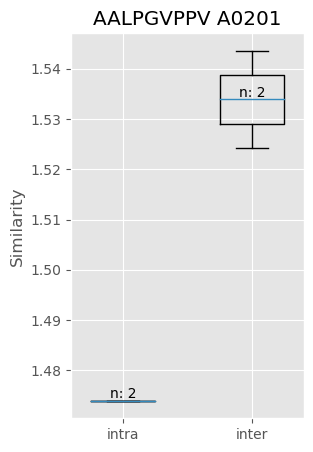

ALPGVPPV A0201


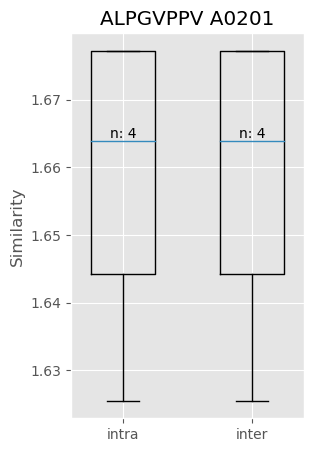

AMLIRDRL B0801


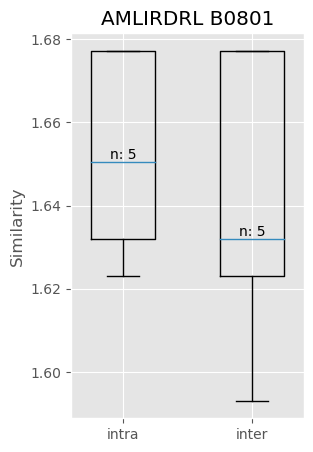

ATTADVDAGSL A0101


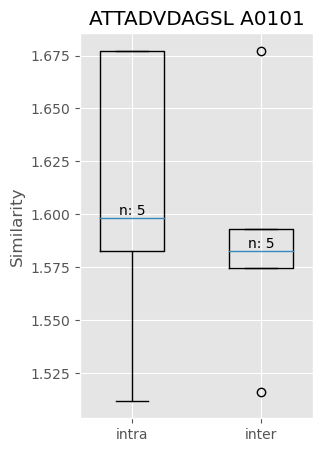

AYLTNQYM A2401


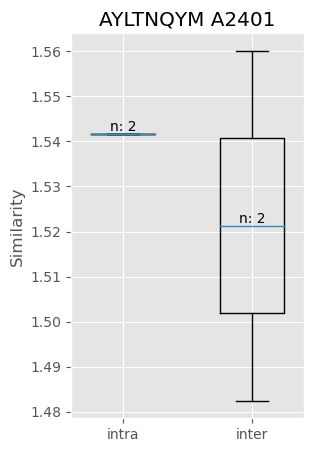

CSSVDIHF A0101


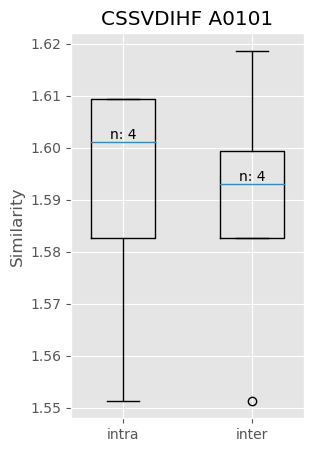

DEYVHNTTA B0801


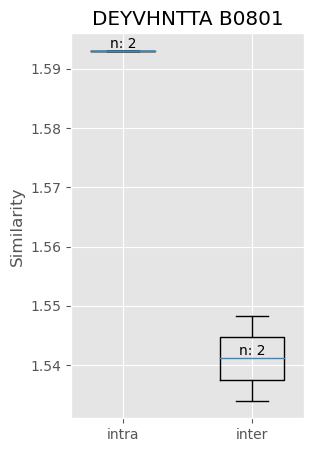

EERQAYLTNQY A0101


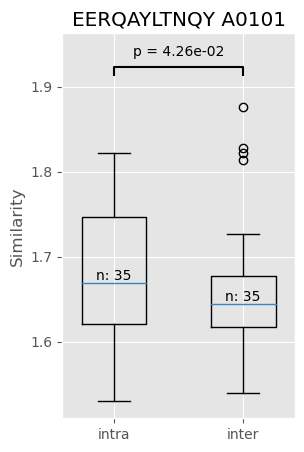

FLDTNQVV A0201


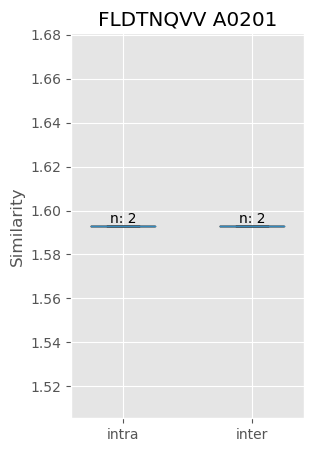

FLDTNQVVRI A0201


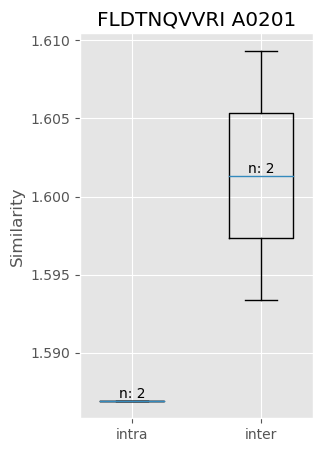

FLVNTMCLAL A0201


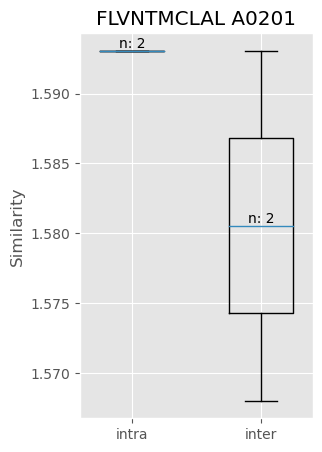

FSAGAFILYK A0101


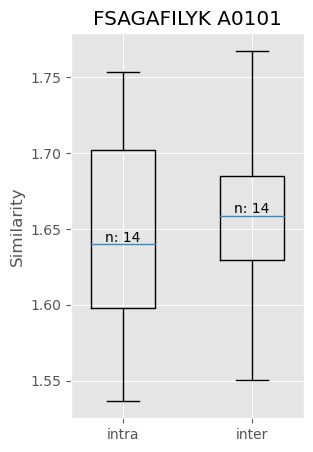

FSAGAFILYN A0101
GLFSAGAFIL A2401


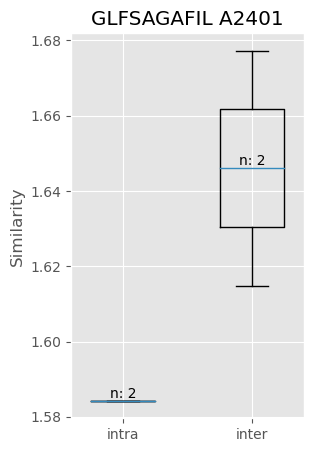

GMAEGATTA A0101


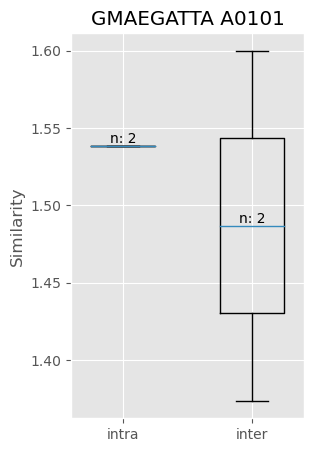

GPFPGNLV B0702
GPFPGNLVD B0702


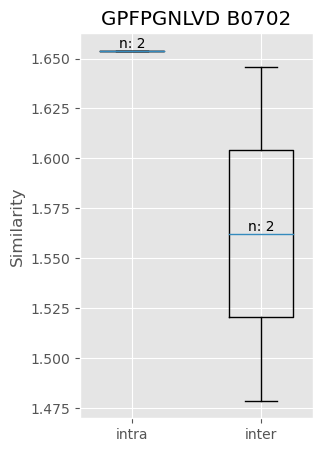

GPFPGNLVDV B0702


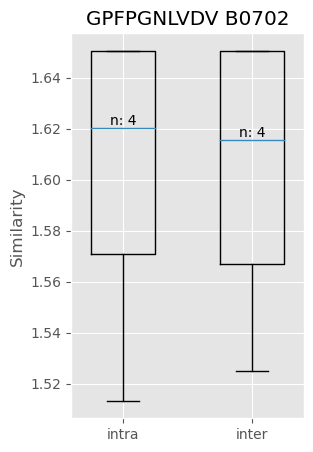

GPKPAKPCSGA B0702
GPRSERRKW B0702
HTGEKHYAC B0801


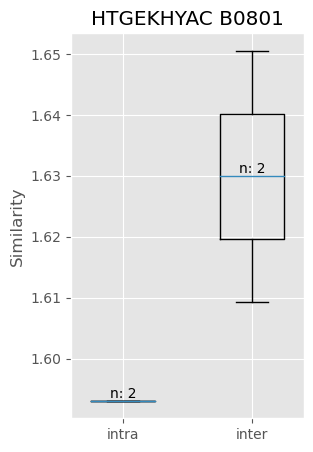

ICSSVDIHF A0101


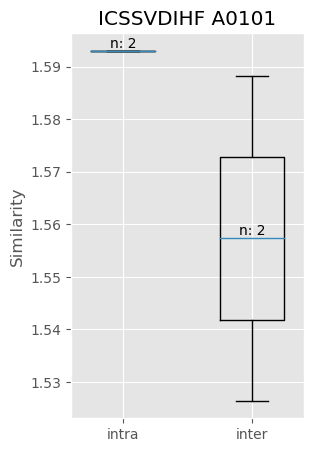

IGLFSAGAFI A2401
IHFDPGFEEQ A0101


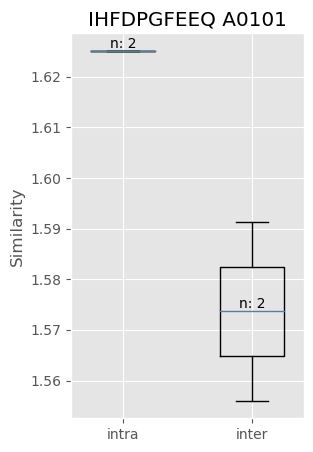

IHFDPGFEEQL A2401
ILKEPVHGV A0201


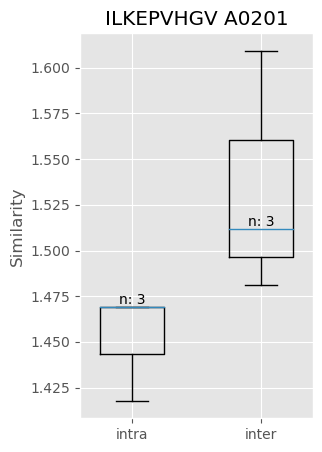

ILLFERPHTM B0801
IRHKRQSW B0801


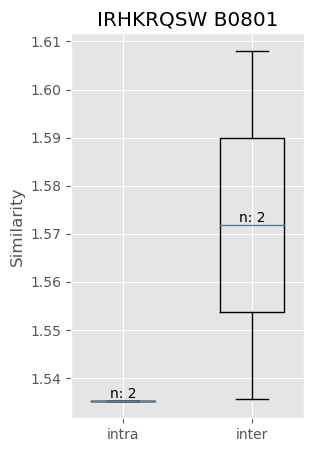

IRHKRQSWV B0801


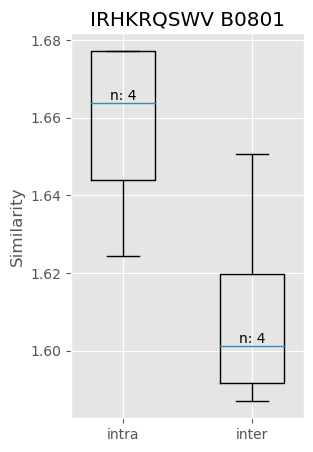

KVPAQRLQEA B0702
LFSAGAFI A2401
LFSAGAFILYN A0101


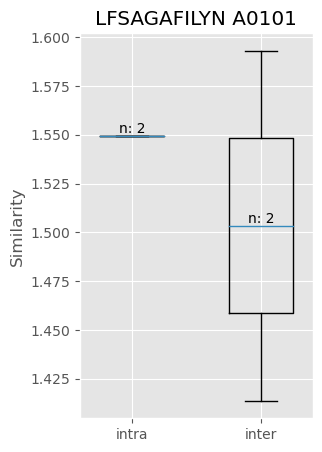

LTNQYMQRM A0101
NLVPMVATV A0201


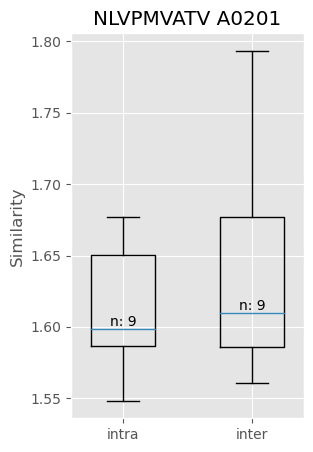

PSTPLKPL B0702
QAYLTNQY A0101


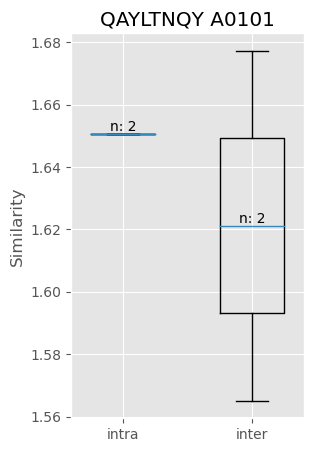

RAKFKQLL B0801


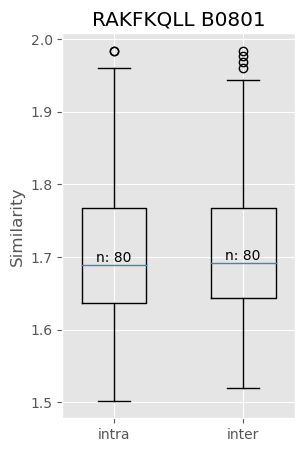

RQAYLTNQY A0101


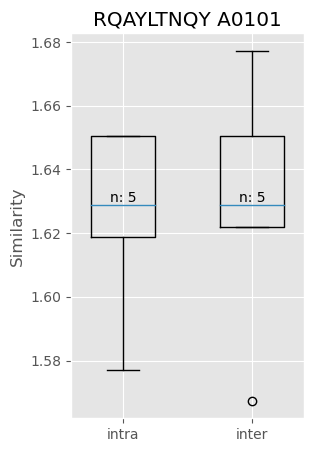

RRKVPAQRL B0801


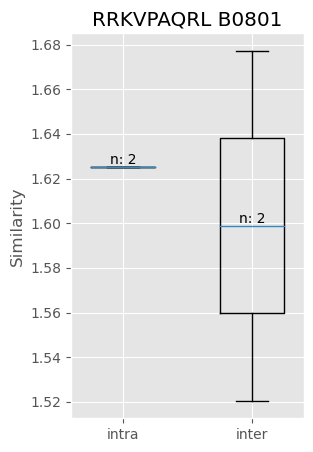

RTMFWGPEV A0201


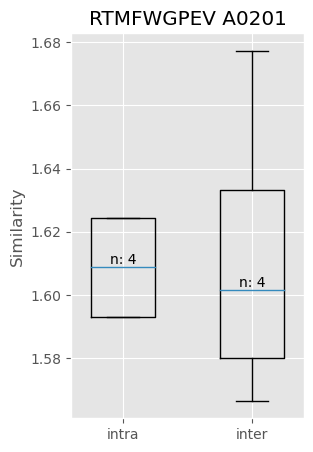

SAGAFILYK A0101


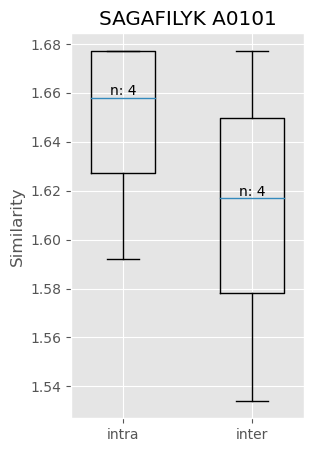

SIKDGLPPV A0201
SLIIQFTSFV A0201


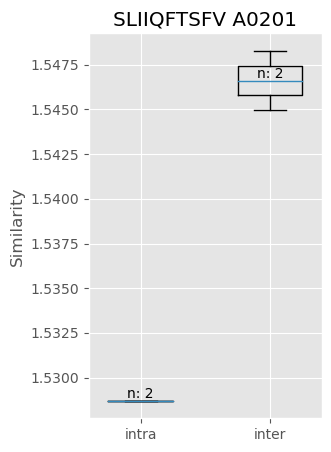

SQKVLRHM B0801


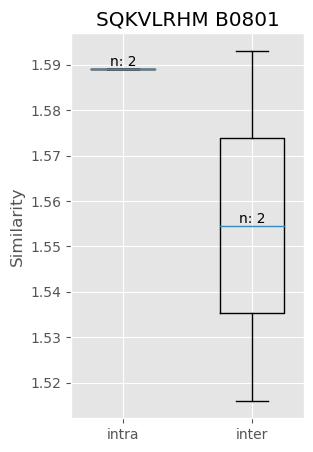

SQSDQTSEL B0801
SSGYRIGQF B0801
SSTEALISV A0201


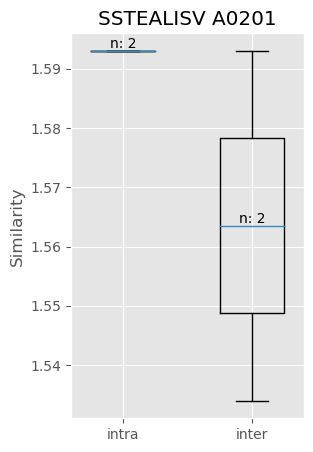

SVDIHFDPG A0101


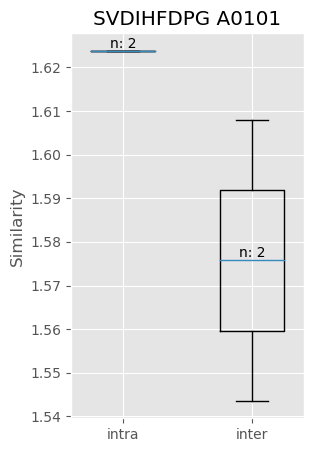

SVDIHFDPGF A0101


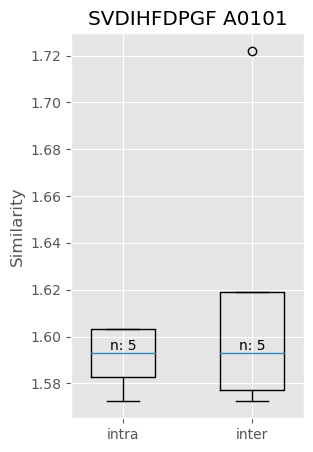

TADVDAGSLS A0101


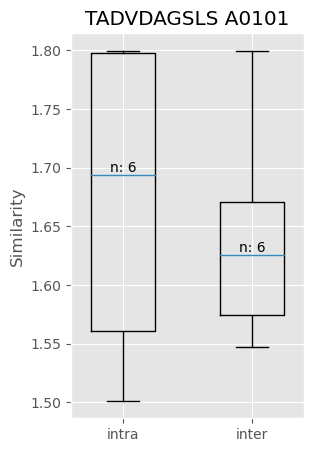

TKFIQTITL B0801
TNQYMQRMASV A2401


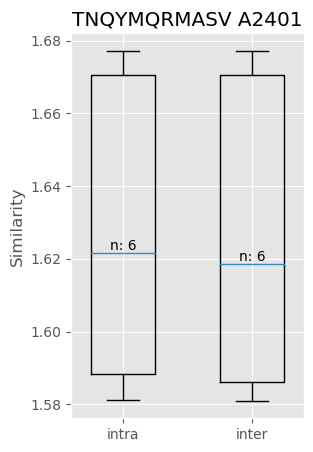

TPRVTGGGAM B0702


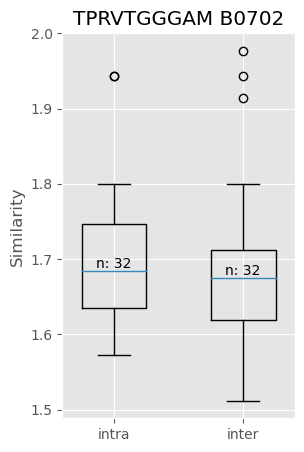

VIRHKRQSW B0801
VPAQRLQEA B0801
VTEHDTLLY A0101


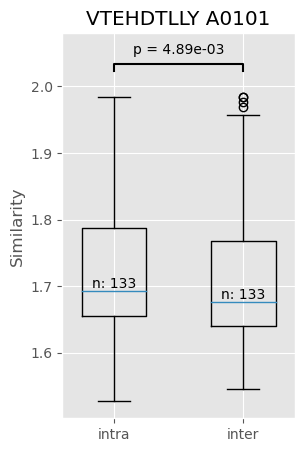

WPRAPRGQ B0702


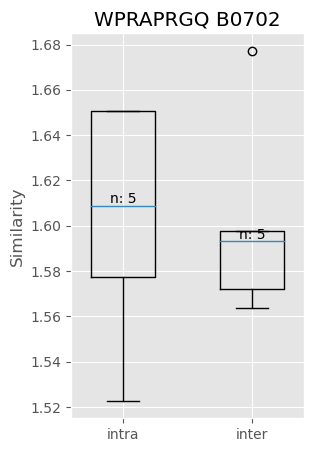

WPRAPRGQI B0801
YLFHKEPTW A0201
YPLVKMRL B0801
YPLVKMRLSV B0702


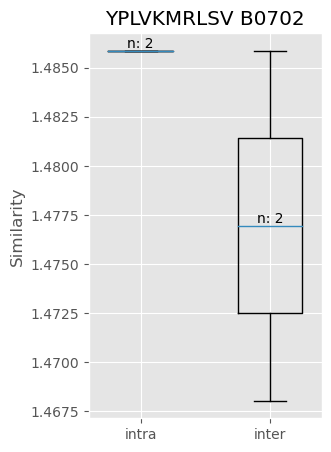

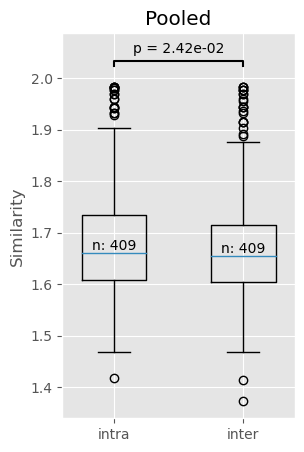

In [71]:
intra_score = list()
inter_score = list()
significant_simulations = list()
n_simulations = 10

#for simulation in range(n_simulations):
for peptide, group in sdf.groupby('peptide_HLA'):
    print(peptide)
    if len(group) == 1:
        continue
    if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
        continue

    inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

    intra_score_peptide = list()
    inter_score_peptide = list()  

    # OBS! Maybe get the pairs directly instead of zipping them? Make sure you get true pairs and not just random pairs?!
    cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
    cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values
    
    assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())
    


    for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
        intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
        inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

        intra_score_peptide.append(intra['score'])
        inter_score_peptide.append(inter['score'])

        intra_score.append(intra['score'])
        inter_score.append(inter['score'])
    
    
    tnobs = len(intra_score_peptide)
    idx = random.sample(list(np.arange(len(intra_score_peptide))), tnobs)
    ass = list(np.array(intra_score_peptide)[idx])
    ess = list(np.array(inter_score_peptide)[idx])
    plot_boxplot(ass, ess, title=peptide)
    #plt.savefig('tcr_similarity.%s.%s.pdf'%(dataset,peptide))
    plt.show()

assert len(inter_score) == len(intra_score)
#tnobs = len(intra_score)
#intra_score_s = random.sample(intra_score, tnobs)
#inter_score_s = random.sample(inter_score, tnobs)
plot_boxplot(intra_score, inter_score) #intra_score_s, inter_score_s
plt.savefig(PLT + 'tcr_similarity.pooled.%s.pdf'%dataset)
plt.show()

In [100]:
sim_dct[dataset] = np.array(intra_score) - np.array(inter_score)

In [101]:
print(sim_dct.keys())

dict_keys(['old.total.14.2.0.2', 'old.raw', 'new.raw'])


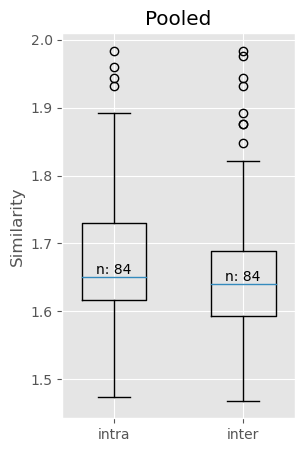

In [73]:
tnobs = 84
idx = random.sample(list(np.arange(len(intra_score))), tnobs)

intra_score_s = list(np.array(intra_score)[idx])
inter_score_s = list(np.array(inter_score)[idx])
plot_boxplot(intra_score_s, inter_score_s)
plt.savefig(PLT + 'tcr_similarity.pooled.%s.downsampled.pdf'%dataset)
plt.show()

# Bayes

In [28]:
import arviz as az
import pymc3 as pm


In [29]:
# OBS!
len(inter_score) == len(intra_score)

True

In [30]:
y = inter_score + intra_score

mu = np.mean(y)
sd = np.std(y) * 2

with pm.Model() as model:
    intra_mean = pm.Normal("intra_mean", mu=mu, sd=sd)
    inter_mean = pm.Normal("inter_mean", mu=mu, sd=sd)

In [31]:
sd_low = 0.1
sd_high = 2

with model:
    intra_std = pm.Uniform("intra_std", lower=sd_low, upper=sd_high)
    inter_std = pm.Uniform("inter_std", lower=sd_low, upper=sd_high)

In [32]:
with model:
    nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1

In [33]:
with model:
    l1 = intra_std ** -2
    l2 = inter_std ** -2

    intra = pm.StudentT("intra", nu=nu, mu=intra_mean, lam=l1, observed=intra_score)
    inter = pm.StudentT("inter", nu=nu, mu=inter_mean, lam=l2, observed=inter_score)

In [34]:
with model:
    diff_of_means = pm.Deterministic("difference of means", intra_mean - inter_mean)
    diff_of_stds = pm.Deterministic("difference of stds", intra_std - inter_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((intra_std ** 2 + inter_std ** 2) / 2)
    )

In [35]:
with model:
    trace = pm.sample(10000, tune=5000) #3000

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, inter_std, intra_std, inter_mean, intra_mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2195.64draws/s]


In [36]:
pm.summary(trace, ["difference of means", "difference of stds", "effect size"])

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
difference of means,0.009,0.007,-0.005,0.023,0.0,0.0,35352.0,28093.0,35356.0,26340.0,1.0
difference of stds,0.001,0.003,-0.004,0.006,0.0,0.0,33737.0,31111.0,32379.0,31269.0,1.0
effect size,0.086,0.073,-0.048,0.225,0.0,0.0,35524.0,28273.0,35527.0,26465.0,1.0


/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


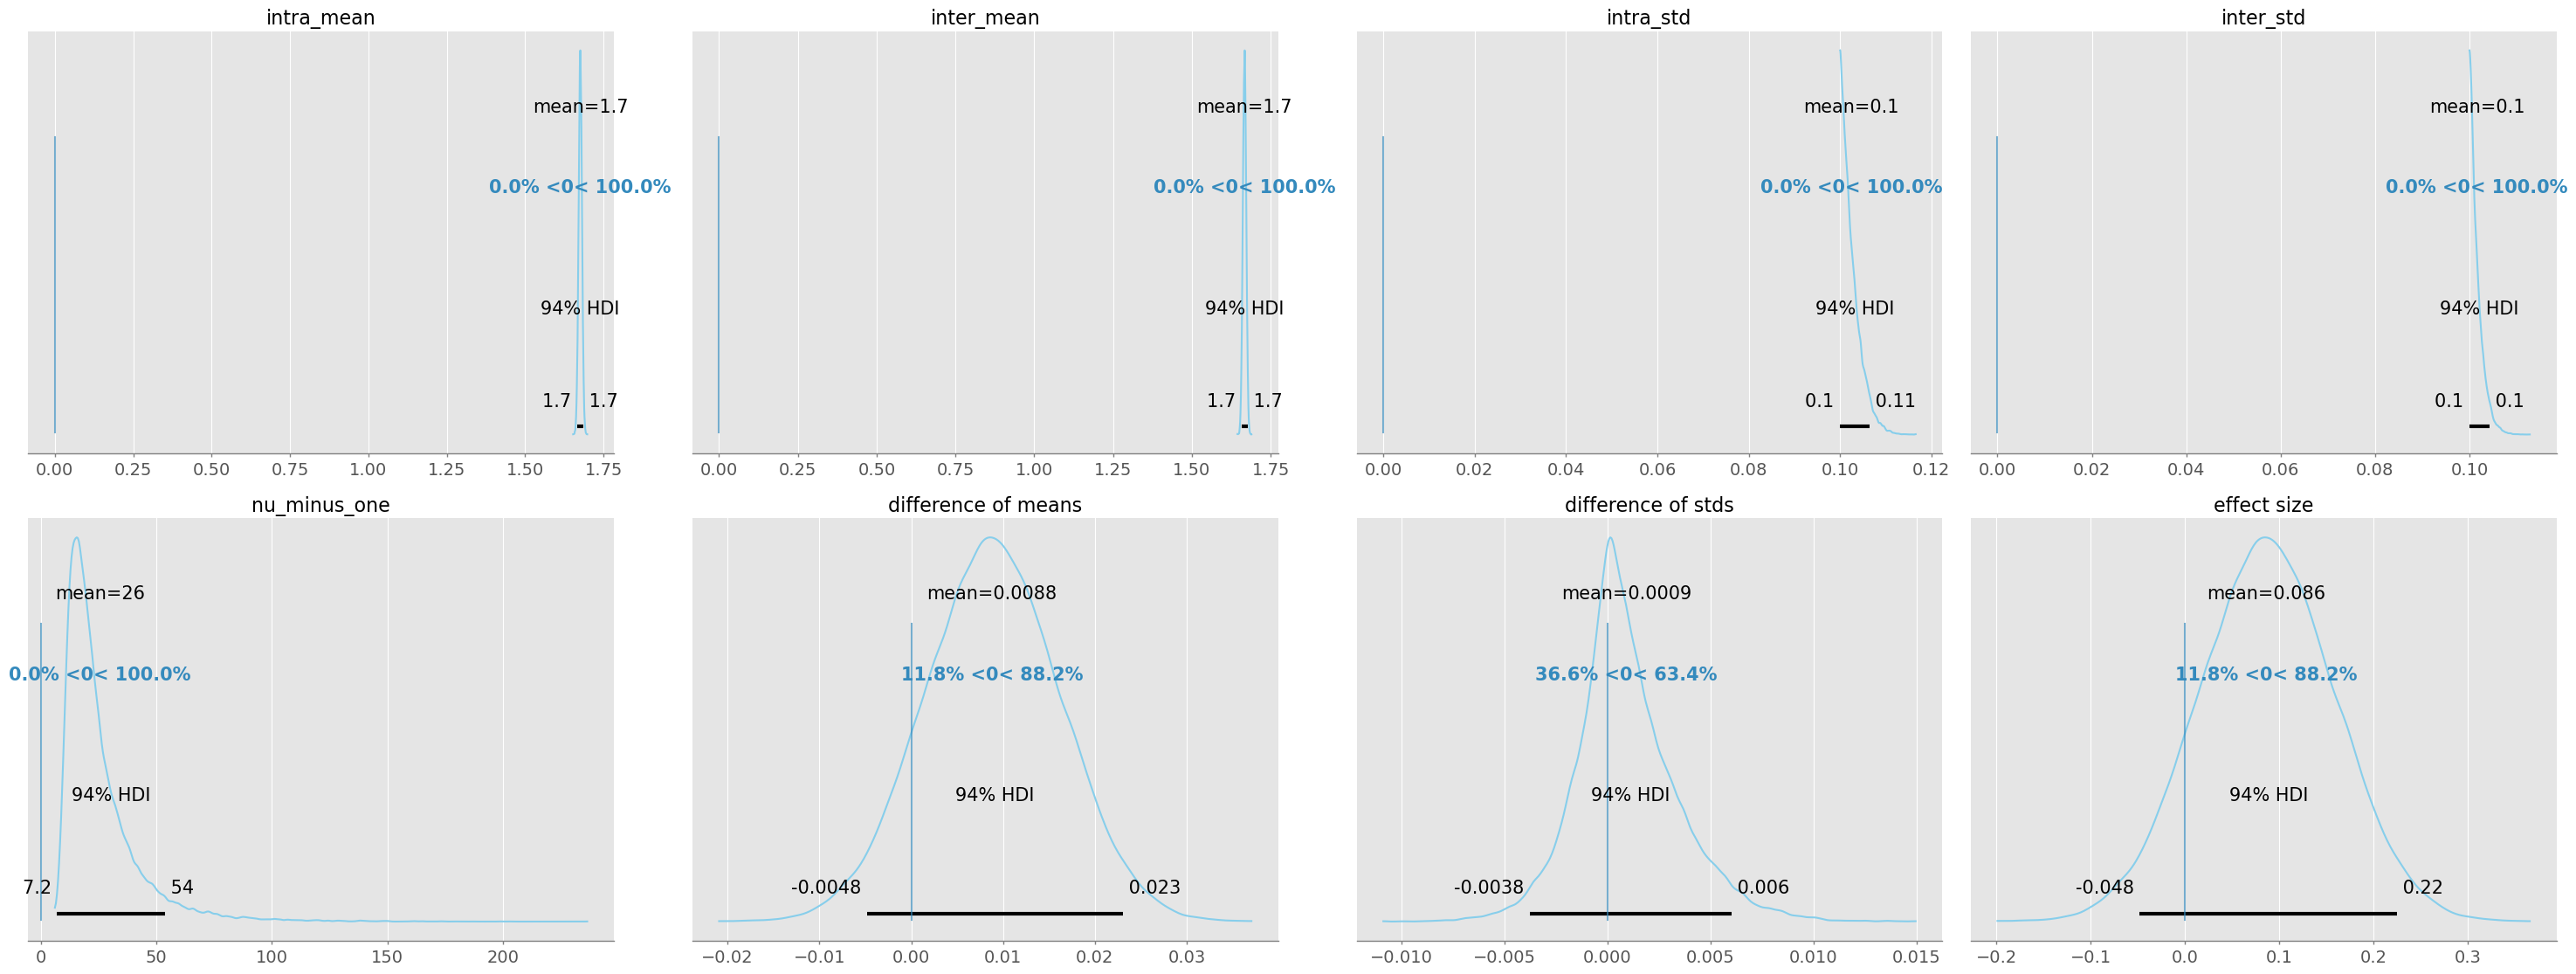

In [37]:
# Train 14.2.0.5
pm.plot_posterior(
    trace,
    ref_val=0,
    color="#87ceeb",
);
plt.show()

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


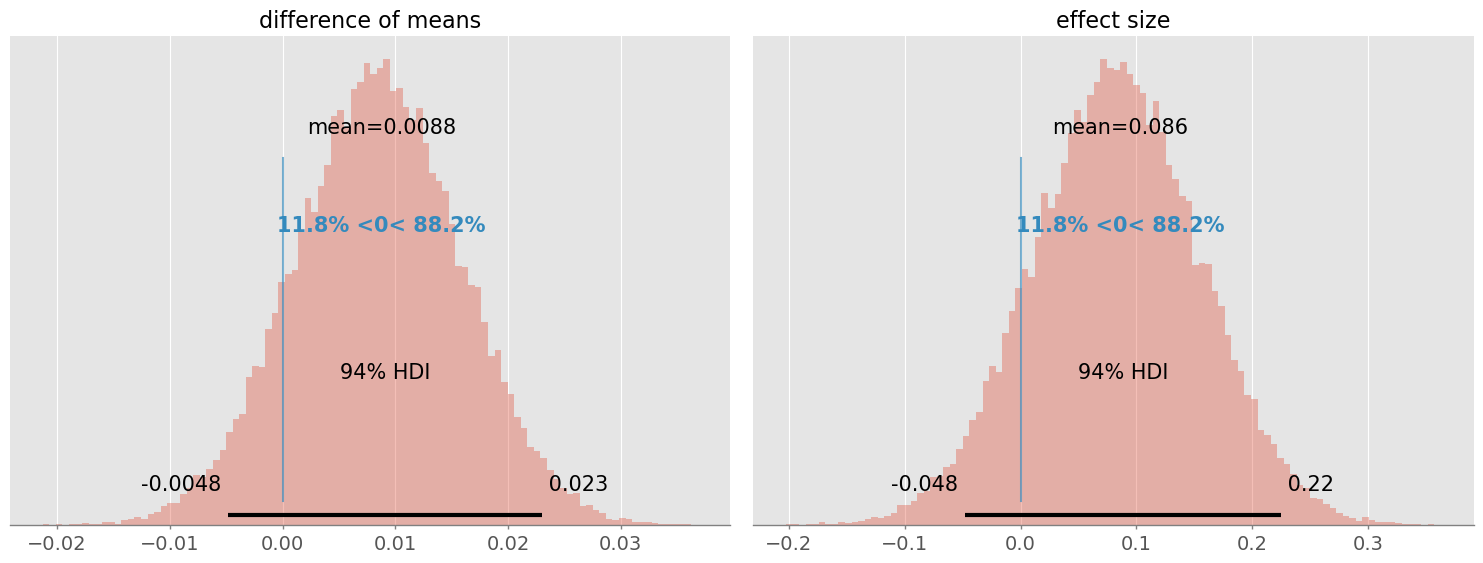

In [38]:
pm.plot_posterior(trace, var_names=['difference of means', 'effect size'], ref_val=0.0, kind='hist')
plt.savefig(PLT + 'tcr_similarity.bayes.%s.pdf'%dataset, bbox_inches='tight')
plt.show()

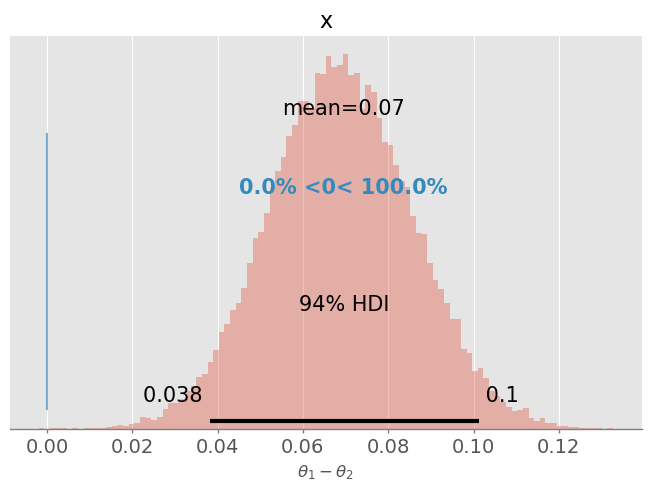

In [55]:
# Test 14.2.0.5
# create an array with the posterior sample
theta1_sample = trace['intra_mean']
theta2_sample = trace['inter_mean']


theta_diff = theta1_sample - theta2_sample
pm.plot_posterior(theta_diff, ref_val=0.0, kind='hist') #, alpha_level=0.05, color='skyblue'
plt.xlabel(r'$\theta_1 - \theta_2$')
plt.savefig('tcr_similarity.bayes.%s.pdf'%dataset, bbox_inches='tight')
plt.show()

Text(0.5, 0, '$\\theta_1 - \\theta_2$')

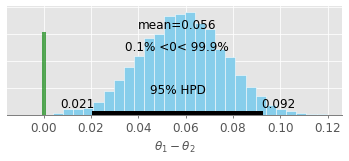

In [199]:
# Total 14.2.0.5
# create an array with the posterior sample
theta1_sample = trace['intra_mean']
theta2_sample = trace['inter_mean']


theta_diff = theta1_sample - theta2_sample
pm.plot_posterior(theta_diff, ref_val=0.0, bins=30, color='skyblue', alpha_level=0.05)
plt.xlabel(r'$\theta_1 - \theta_2$')

Text(0.5, 0, '$\\theta_1 - \\theta_2$')

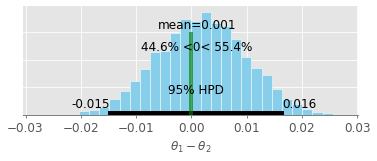

In [237]:
# Trash 14.2.0.5
# create an array with the posterior sample
theta1_sample = trace['intra_mean']
theta2_sample = trace['inter_mean']


theta_diff = theta1_sample - theta2_sample
pm.plot_posterior(theta_diff, ref_val=0.0, bins=30, color='skyblue', alpha_level=0.05)
plt.xlabel(r'$\theta_1 - \theta_2$')